In [1]:
import os, gc, torch, PIL

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from matplotlib.patches import Rectangle
from data.dataset import ReflacxDataset
from data.dataset import collate_fn
from utils.transforms import get_transform
from utils.plot import  get_legend_elements, disease_cmap
from utils.pred import pred_thrs_check
from models.rcnn import get_model_instance_segmentation, get_multimodal_model_instance_segmentation

## Suppress the assignement warning from pandas.
pd.options.mode.chained_assignment = None  # default='warn

## Supress user warning
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

%matplotlib inline

In [2]:
XAMI_MIMIC_PATH = "D:\XAMI-MIMIC"

use_clinical = False
use_custom_modal = True

In [3]:
def get_bouding_box(annotated_img_path, orginial_img_path):

    annotated_img = PIL.Image.open(annotated_img_path).convert("RGB")
    original_img = PIL.Image.open(orginial_img_path).convert("RGB")

    annotated_img_arr = np.array(annotated_img)
    a_y, a_x = np.where(
        (
            (annotated_img_arr[:, :, 0] != annotated_img_arr[:, :, 1])
            | (annotated_img_arr[:, :, 0] != annotated_img_arr[:, :, 2])
        )
    )

    a_x_max = a_x.max()
    a_x_min = a_x.min()
    a_y_max = a_y.max()
    a_y_min = a_y.min()

    a_w, a_h = annotated_img.size
    o_w, o_h = original_img.size

    o_x_max = a_x_max * (o_w / a_w)
    o_x_min = a_x_min * (o_w / a_w)
    o_y_max = a_y_max * (o_h / a_h)
    o_y_min = a_y_min * (o_h / a_h)

    return np.array([o_x_min, o_y_min, o_x_max, o_y_max])


In [4]:
all_dicom_ids = {
    "A": "ec72dd86-36c802f0-20a909ca-8cbcc950-58733cd5",
    "B": "683aad2e-41beb1a8-9d1872c4-125b275a-ef29a7d6",
    "C": "4d994f76-a7de771a-cf65cd0f-c1250201-f04a9626",
    "D": "4288be3d-ae1b69d3-0be85637-a5236d5b-be4ac4af",
    "E": "05dd9e22-b8766b89-49e21ff4-9cad2776-908d4c9f",
    "F": "e6114f27-d0cdef4a-13ef26b5-86198fa7-0890f0be",
    "G": "a04250da-25655fa3-7b75e707-a862738a-375e4e9f",
    "H": "dffe7130-cb1ee280-5aee23a9-754b56f9-b20c2a3c",
    "I": "70e31905-dd605e80-305f056b-4f88ec80-cbb4b3fb",
    "J": "6d7c4296-157fc904-b6d6c70d-f3c54944-61ba51e2",
    "K": "82043e9e-dc650774-246cc5bd-efb75286-bebc4801",
    "L": "53588137-69f5216f-022b1177-b7ed05ef-9a670fd8",
    "M": "90bba64d-6913b983-a1740cf9-5fb87f7e-9171482d",
    # "N": "919158fb-4f0d9b66-46719ab6-5d584449-1a3ad8de", # No.
    "O": "ce6c73a2-bfbdbdf8-f7f014a2-bfffc5e3-232d2d80",
    "P": "425d59af-b3a07390-48699ce4-edd9cf7d-3b4faafe",
    "Q": "a04250da-25655fa3-7b75e707-a862738a-375e4e9f",
    "R": "cd27ccb8-f83311dd-ceacc3b7-501d40c2-6f1071f8",
    "S": "4a04164c-bf7a47b2-39273bf3-6f841e34-278431eb",
    "T": "467886fc-bdd148bc-96415ce2-3ea24428-0ee1d9a1",
    "U": "315a2ff9-d2cc7585-47e3c881-524b9634-158b6ae8",
    "V": "1201d2ae-1e36ac1e-037a7be9-82d08c96-044333da",
    "W": "919158fb-4f0d9b66-46719ab6-5d584449-1a3ad8de",
    "X": "f24dcfb8-8d336748-8d0d5686-a52f7cc9-2aefd3a6",
    "Y": "4288be3d-ae1b69d3-0be85637-a5236d5b-be4ac4af",
}

In [5]:
for k, d_id in all_dicom_ids.items():
    os.makedirs(f"radiologists_annotated/{k}_{d_id}/", exist_ok=True)

In [6]:
labels_cols = [
    "Enlarged cardiac silhouette",
    "Atelectasis",
    "Pleural abnormality",
    "Consolidation",
    "Pulmonary edema",
    #  'Groundglass opacity', # 6th disease.
]

dataset_params_dict = {
    "XAMI_MIMIC_PATH": XAMI_MIMIC_PATH,
    "with_clinical": use_clinical,
    "using_full_reflacx": False,
    "bbox_to_mask": True,
    "labels_cols": labels_cols,
}

detect_eval_dataset = ReflacxDataset(
    **{**dataset_params_dict, "using_full_reflacx": False,},
    transforms=get_transform(train=False),
)

In [7]:
radiologists_anns = []
for k, d_id in all_dicom_ids.items():
    bboxes = []
    image_path = detect_eval_dataset.get_image_path_from_dicom_id(d_id)
    for file in os.listdir(os.path.join("radiologists_annotated", f"{k}_{d_id}")):
        if file.endswith(".png"):
            # print(file)
            disease = file.split("-")[0]
            bbox = get_bouding_box(
                os.path.join("radiologists_annotated", f"{k}_{d_id}", file),
                image_path,
            ).astype(int)

            bboxes.append(
                {
                    "label": detect_eval_dataset.disease_to_idx(disease),
                    "box": bbox,
                }
            )

    radiologists_anns.append({
        "labels":torch.tensor([b['label'] for b in  bboxes]),
        "boxes": torch.tensor([b['box'] for b in bboxes]),
        "image_path": image_path,
        "dicom_id": d_id,
        "encoding": k
    })


In [8]:
gc.collect()
# torch.cuda.memory_summary(device=None, abbreviated=False)

use_gpu = torch.cuda.is_available()
device = 'cuda' if use_gpu else 'cpu'
print(f"This notebook will running on device: [{device}]")

if use_gpu:
    torch.cuda.empty_cache()

This notebook will running on device: [cuda]


In [9]:
model_path_dict = {
    "custom": {
        "with_clinical": "val_ar_0_3909_ap_0_1828_test_ar_0_3808_ap_0_1542_epoch39_WithClincal_03-14-2022 17-14-52",
        "without_clinical": "val_ar_0_3410_ap_0_1753_test_ar_0_3553_ap_0_1832_epoch33_WithoutClincal_03-14-2022 19-10-27",
    },
    "original": {
        "with_clinical": None,
        "without_clinical": "val_ar_0_3000_ap_0_1542_test_ar_0_3504_ap_0_1386_epoch15_WithoutClincal_03-14-2022 03-10-11",
    },
}


final_model_path = model_path_dict["custom" if use_custom_modal else "original"][
    "with_clinical" if use_clinical else "without_clinical"
]

legend_elements = get_legend_elements(disease_cmap["solid"])


assert not final_model_path is None, "Doesn't have the model yet."


In [10]:
if use_custom_modal:
    model = get_multimodal_model_instance_segmentation(
        len(detect_eval_dataset.labels_cols) + 1, use_clinical=use_clinical,
    )

else:
    model = get_model_instance_segmentation(
        len(detect_eval_dataset.labels_cols) +1,
    )

model.to(device)

model.load_state_dict(
    torch.load(os.path.join("trained_models", final_model_path), map_location=device)
)

model.eval()

{'rpn_nms_thresh': 0.3, 'box_detections_per_img': 6, 'box_nms_thresh': 0.2, 'rpn_score_thresh': 0.0, 'box_score_thresh': 0.05}
c1
None


MultimodalMaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu

In [11]:
def plot_three_bbox(
    ann, target, pred, label_idx_to_disease, legend_elements, disease_color_code_map
):

    fig, (gt_ax, pred_ax, ann_ax) = plt.subplots(1, 3, figsize=(30, 10), dpi=80, sharex=True)

    fig.suptitle(f"{target['image_path']}_({ann['encoding']})")

    fig.legend(handles=legend_elements, loc="upper right")

    img = PIL.Image.open(target["image_path"]).convert("RGB")

    gt_ax.imshow(img)
    gt_ax.set_title(f"REFLACX ({len(target['boxes'].detach().cpu().numpy())})")
    pred_ax.imshow(img)
    pred_ax.set_title(f"Predictions ({len(pred['boxes'].detach().cpu().numpy())})")
    ann_ax.imshow(img)
    ann_ax.set_title(f"Our Radiologists ({len(ann['boxes'].detach().cpu().numpy())})")

    # load image
    gt_recs = []
    pred_recs = []
    ann_recs = []

    for label, bbox, score in zip(
        pred["labels"].detach().cpu().numpy(),
        pred["boxes"].detach().cpu().numpy(),
        pred["scores"].detach().cpu().numpy(),
    ):
        disease = label_idx_to_disease(label)
        c = disease_color_code_map[disease]
        pred_recs.append(
            Rectangle(
                (bbox[0], bbox[1]),
                bbox[2] - bbox[0],
                bbox[3] - bbox[1],
                fill=False,
                color=c,
                linewidth=2,
            )
        )
        pred_ax.text(
            bbox[0],
            bbox[1],
            f"{disease} ({score:.2f})",
            color="black",
            backgroundcolor=c,
        )

    for rec in pred_recs:
        pred_ax.add_patch(rec)

    for label, bbox in zip(
        target["labels"].detach().cpu().numpy(), target["boxes"].detach().cpu().numpy()
    ):
        disease = label_idx_to_disease(label)
        c = disease_color_code_map[disease]
        gt_recs.append(
            Rectangle(
                (bbox[0], bbox[1]),
                bbox[2] - bbox[0],
                bbox[3] - bbox[1],
                fill=False,
                color=c,
                linewidth=2,
            )
        )
        gt_ax.text(bbox[0], bbox[1], disease, color="black", backgroundcolor=c)

    for rec in gt_recs:
        gt_ax.add_patch(rec)


    
    for label, bbox in zip(
        ann["labels"].detach().cpu().numpy(), ann["boxes"].detach().cpu().numpy()
    ):
        disease = label_idx_to_disease(label)
        c = disease_color_code_map[disease]
        ann_recs.append(
            Rectangle(
                (bbox[0], bbox[1]),
                bbox[2] - bbox[0],
                bbox[3] - bbox[1],
                fill=False,
                color=c,
                linewidth=2,
            )
        )
        ann_ax.text(bbox[0], bbox[1], disease, color="black", backgroundcolor=c)

    for rec in ann_recs:
        ann_ax.add_patch(rec)

    plt.plot()
    plt.pause(0.01)

    return fig


In [12]:
# from utils.engine import xami_evaluate
# from utils.coco_eval import get_ar_ap, get_eval_params_dict
# eval_params_dict = get_eval_params_dict(detect_eval_dataset)

# test_dataset = ReflacxDataset(
#     **dataset_params_dict, split_str="test", transforms=get_transform(train=False),
# )

# test_dataloader = torch.utils.data.DataLoader(
#     test_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn,
# )

# model.roi_heads.score_thresh = 0.3

# score_thres= {
#     'Enlarged cardiac silhouette': 0.3,
#     'Atelectasis': 0.2,
#     'Pleural abnormality': 0.1,
#     'Consolidation': 0.05,
#     'Pulmonary edema': 0.1,
# }

# test_evaluator = xami_evaluate(
#     model,
#     test_dataloader,
#     device=device,
#     params_dict=eval_params_dict,
#     score_thres=None,
# )

# test_ar, test_ap = get_ar_ap(test_evaluator)

# # 0.23623015873015873 0.11900175731858897 (0.01, thrs)
# # 0.35710317460317464 0.1440243872224295 (0.01, None)
# # 0.22956349206349205 0.11206579987412377 (0.05, thrs)
# # 0.35710317460317464 0.14248711487254806 (0.05, None)
# # 0.21103174603174607 0.1446907131542274 (0.3, None)

# print(test_ar, test_ap)


In [13]:
score_thres= {
    'Enlarged cardiac silhouette': 0.4,
    'Atelectasis': 0.2,
    'Pleural abnormality': 0.2,
    'Consolidation': 0.1,
    'Pulmonary edema': 0.2,
}

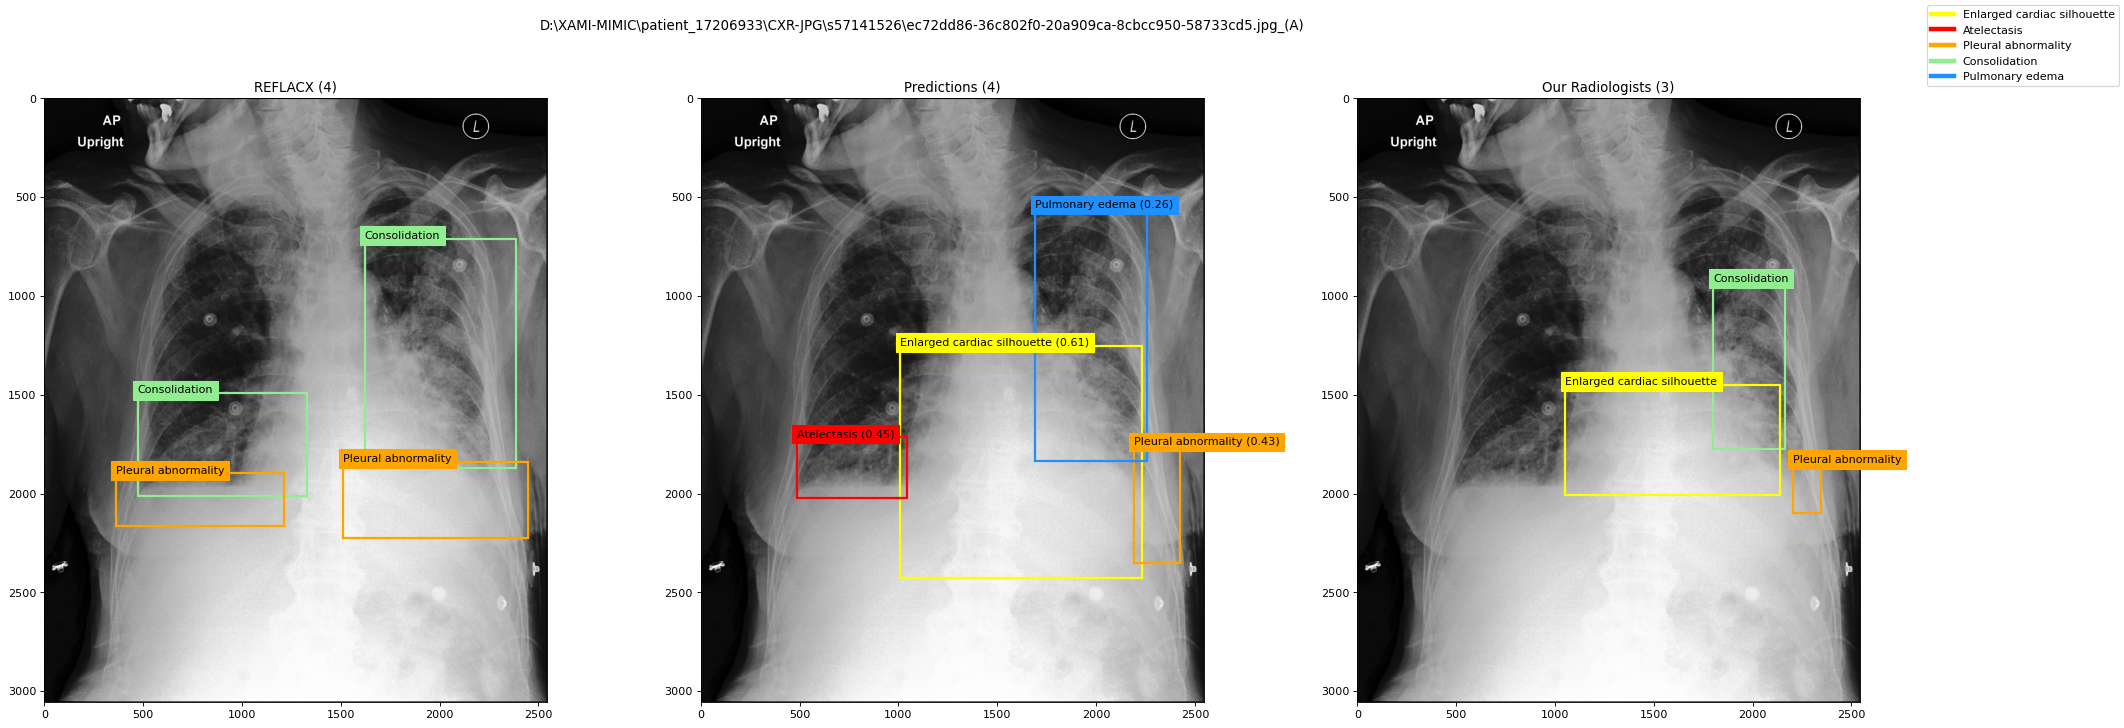

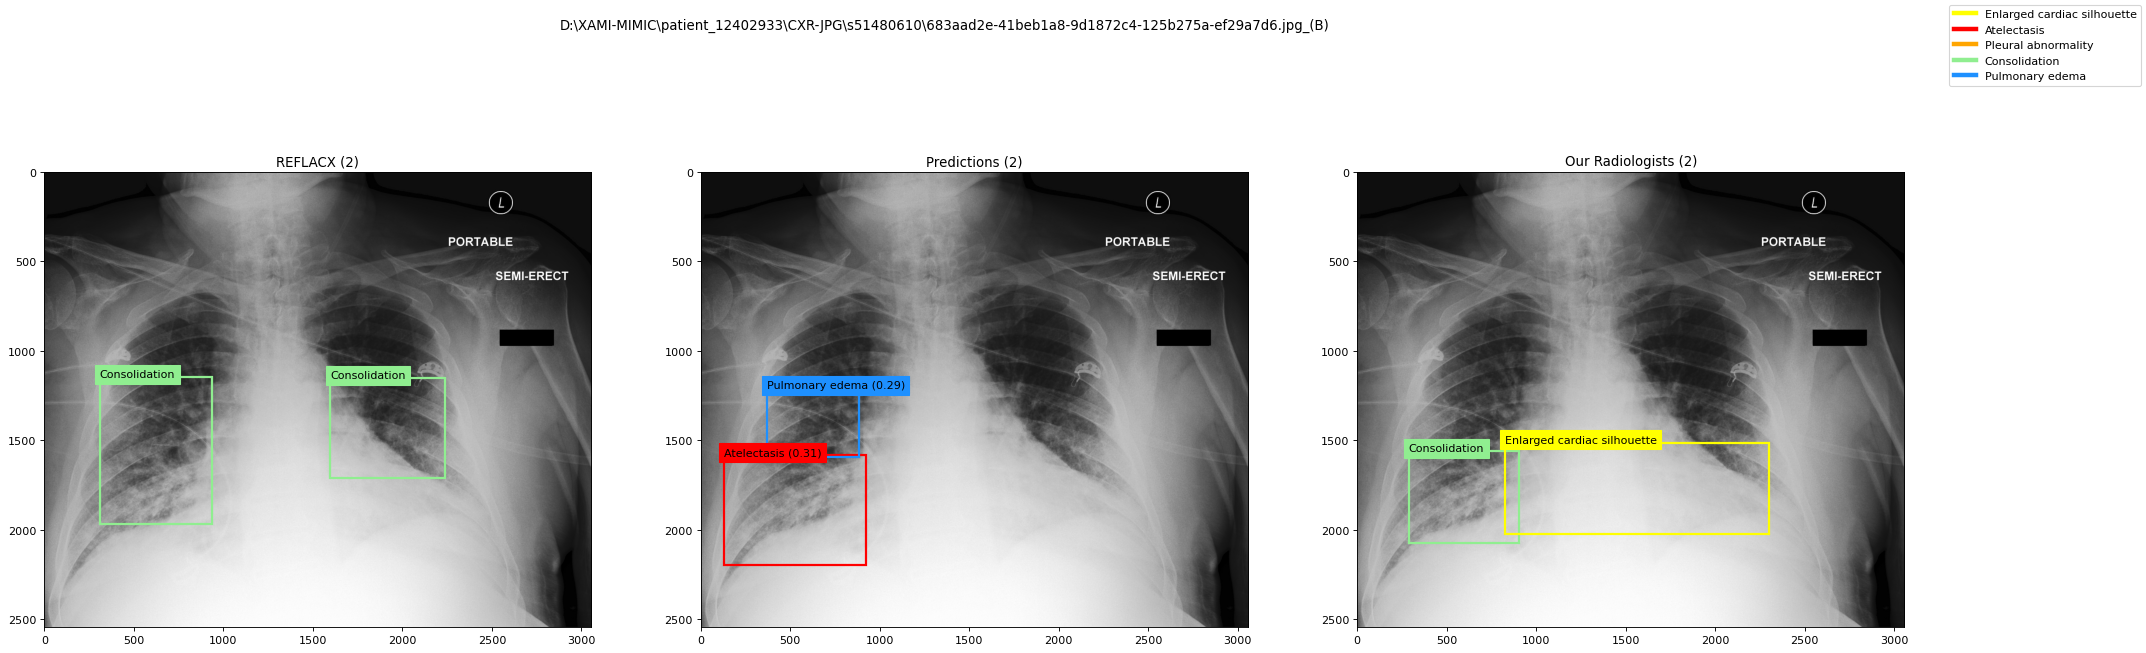

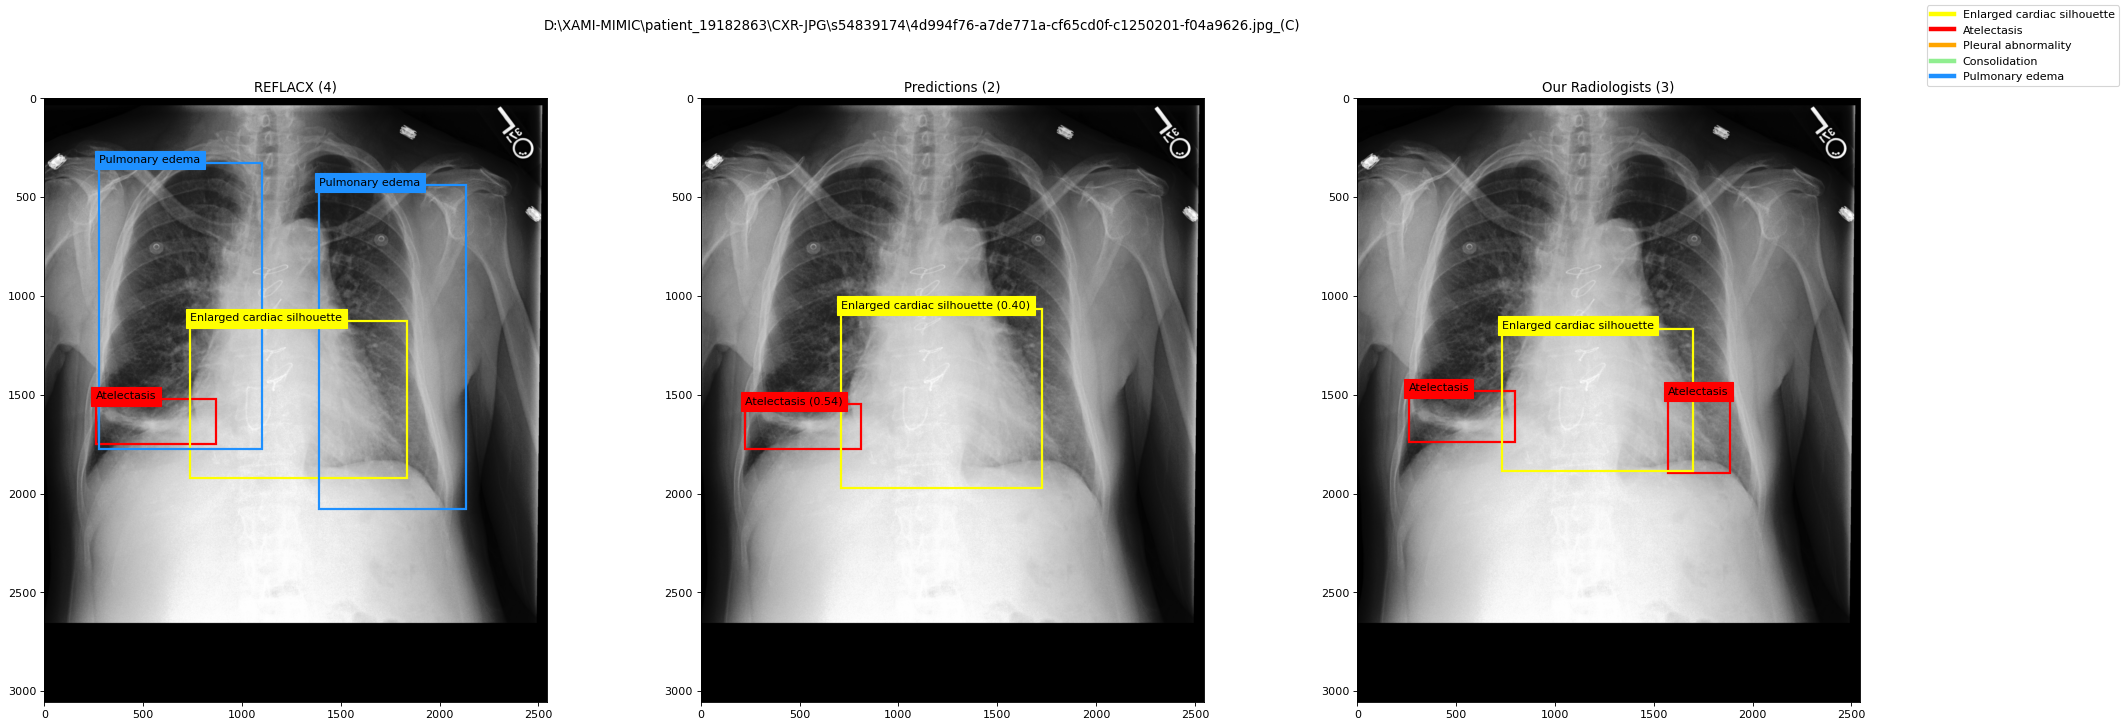

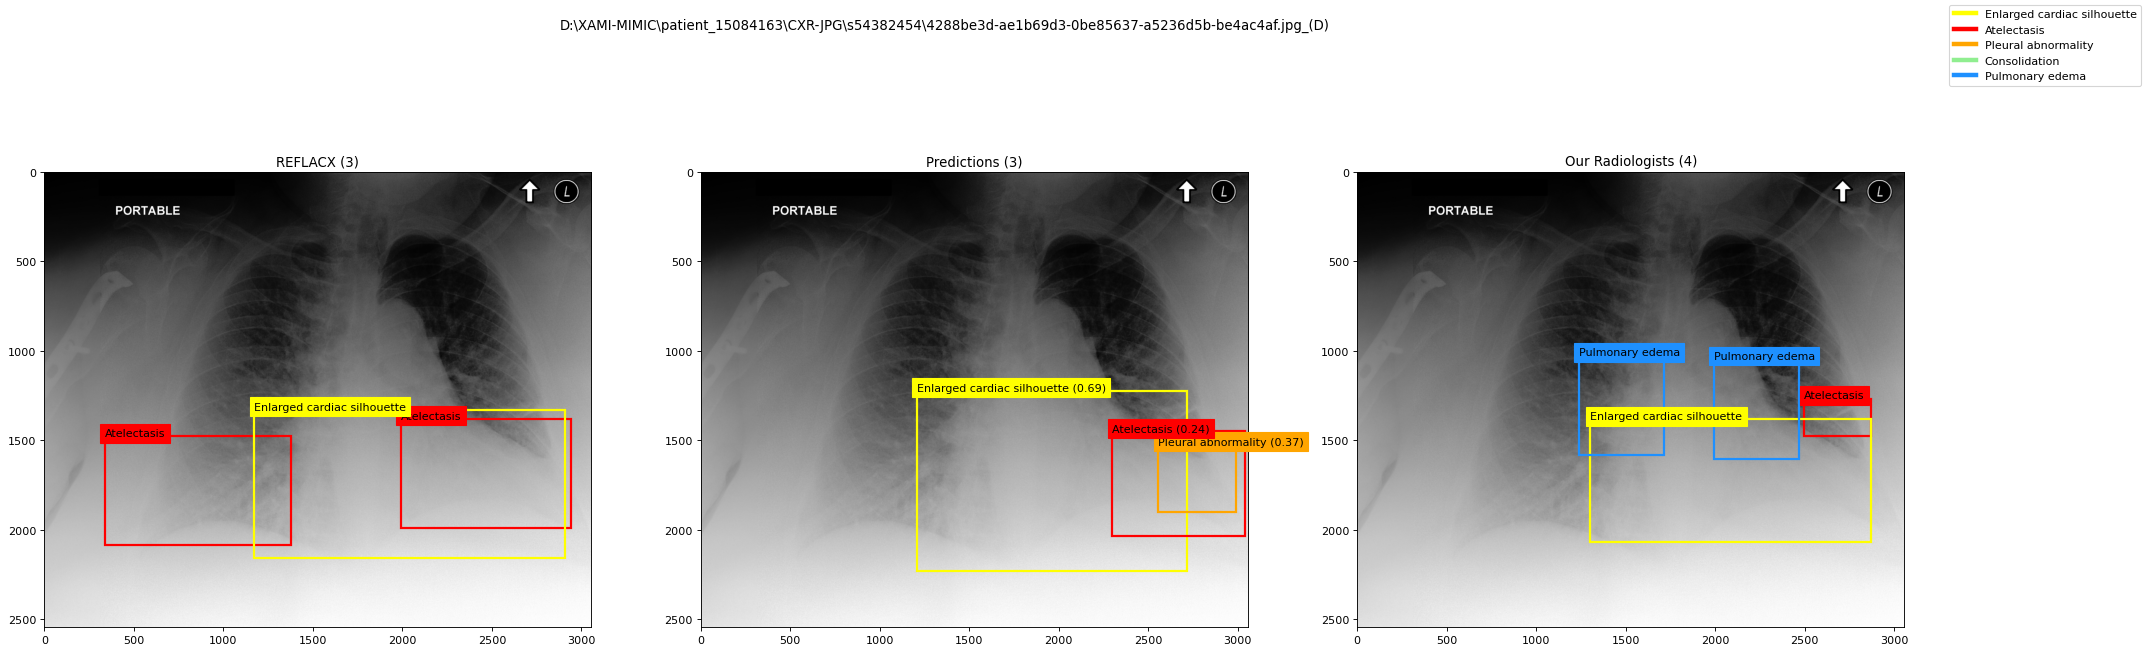

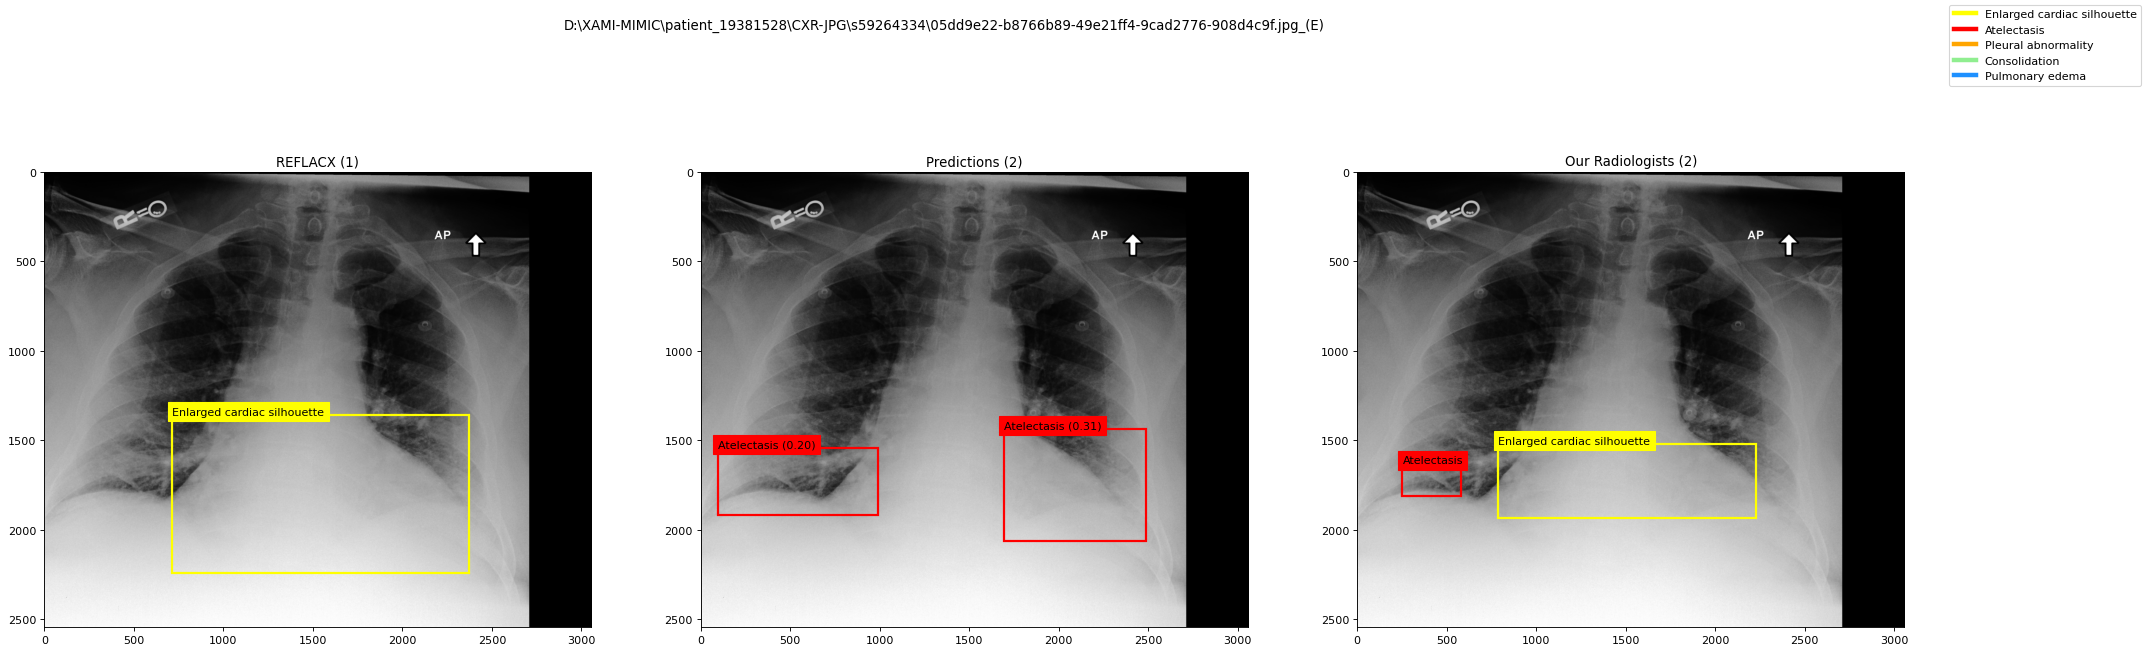

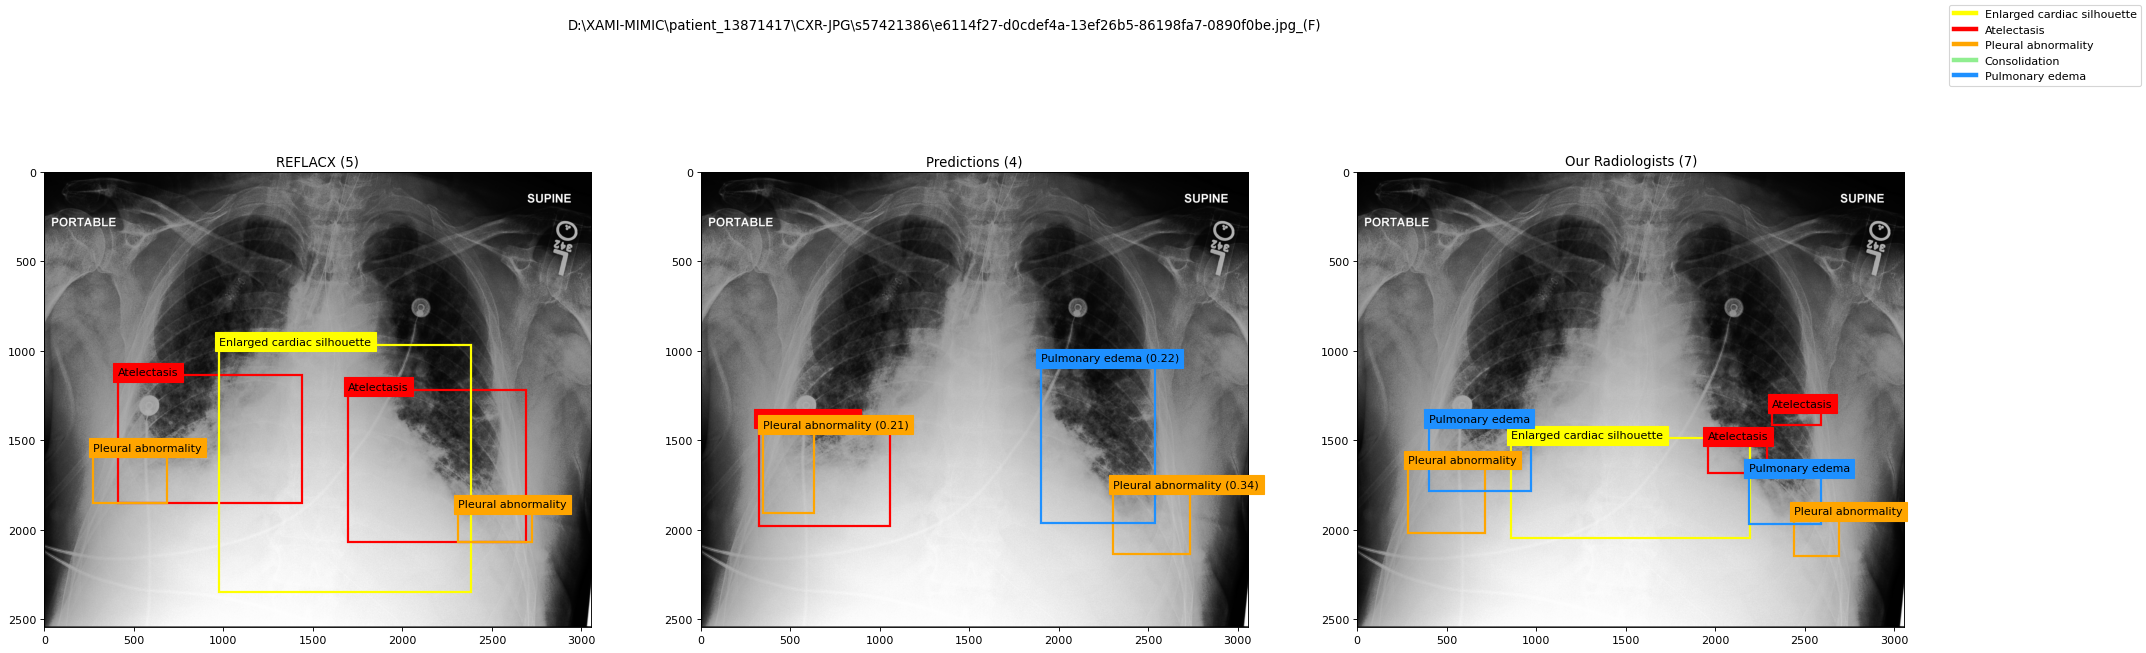

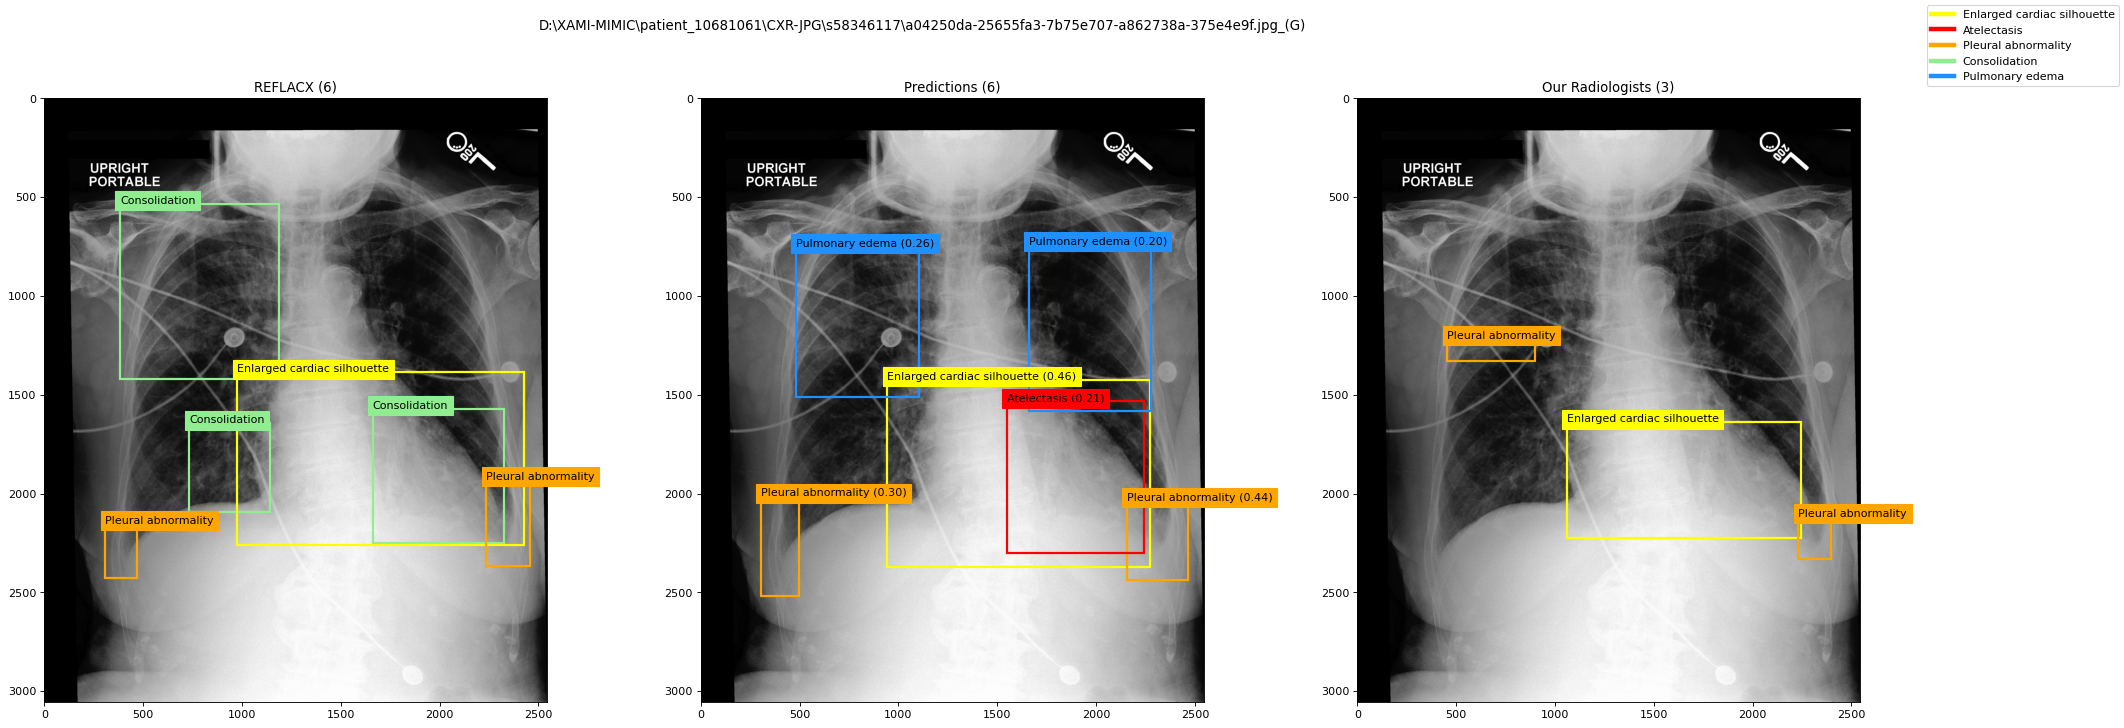

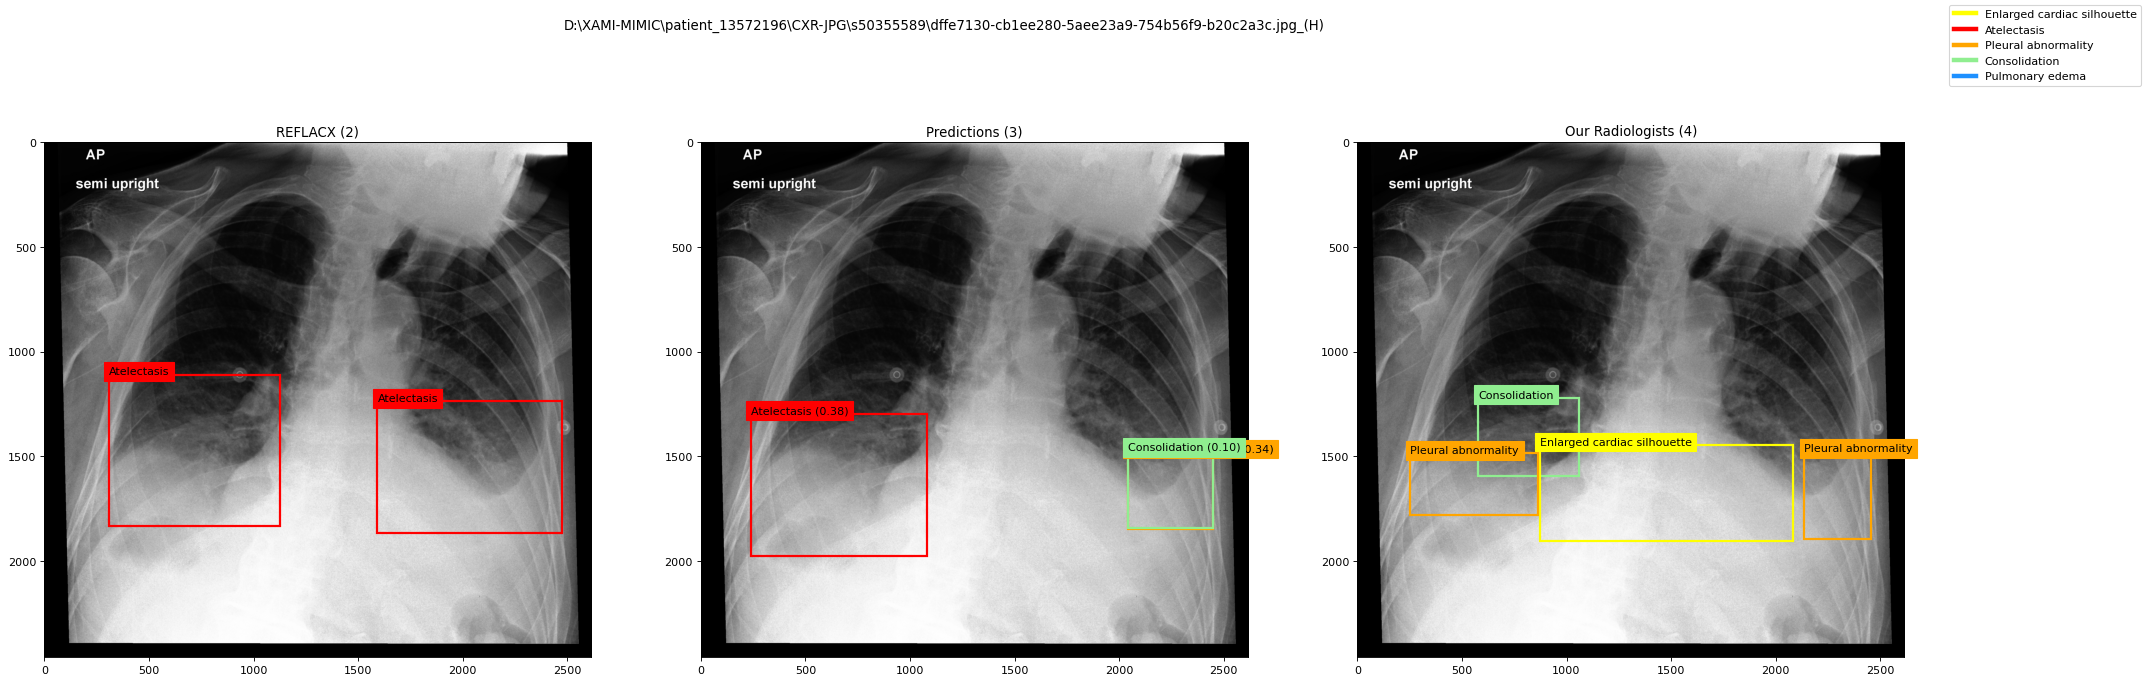

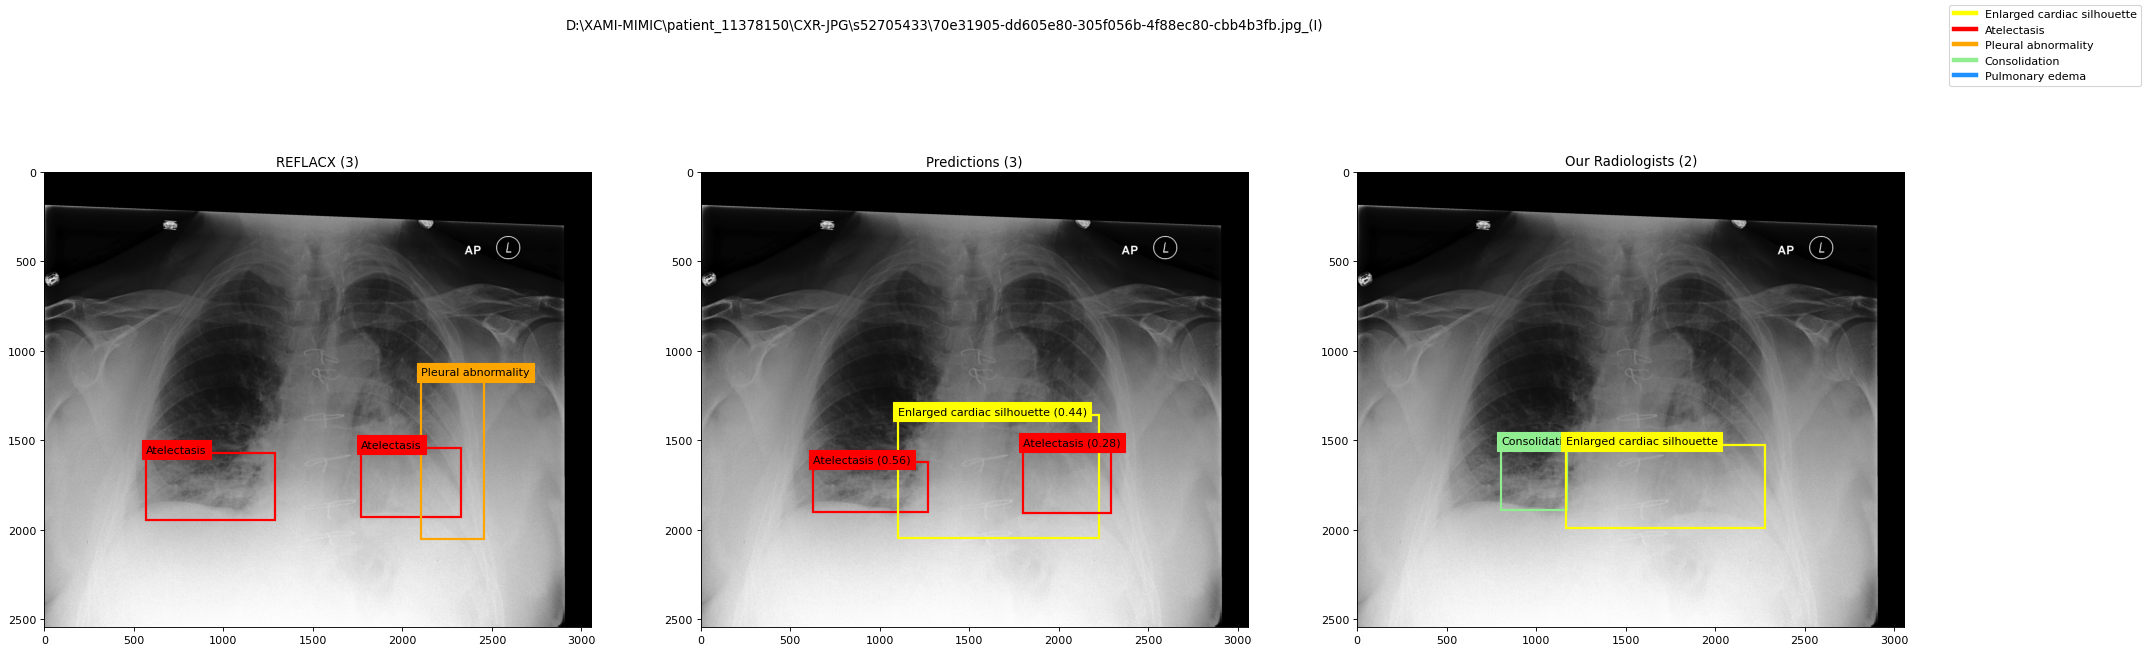

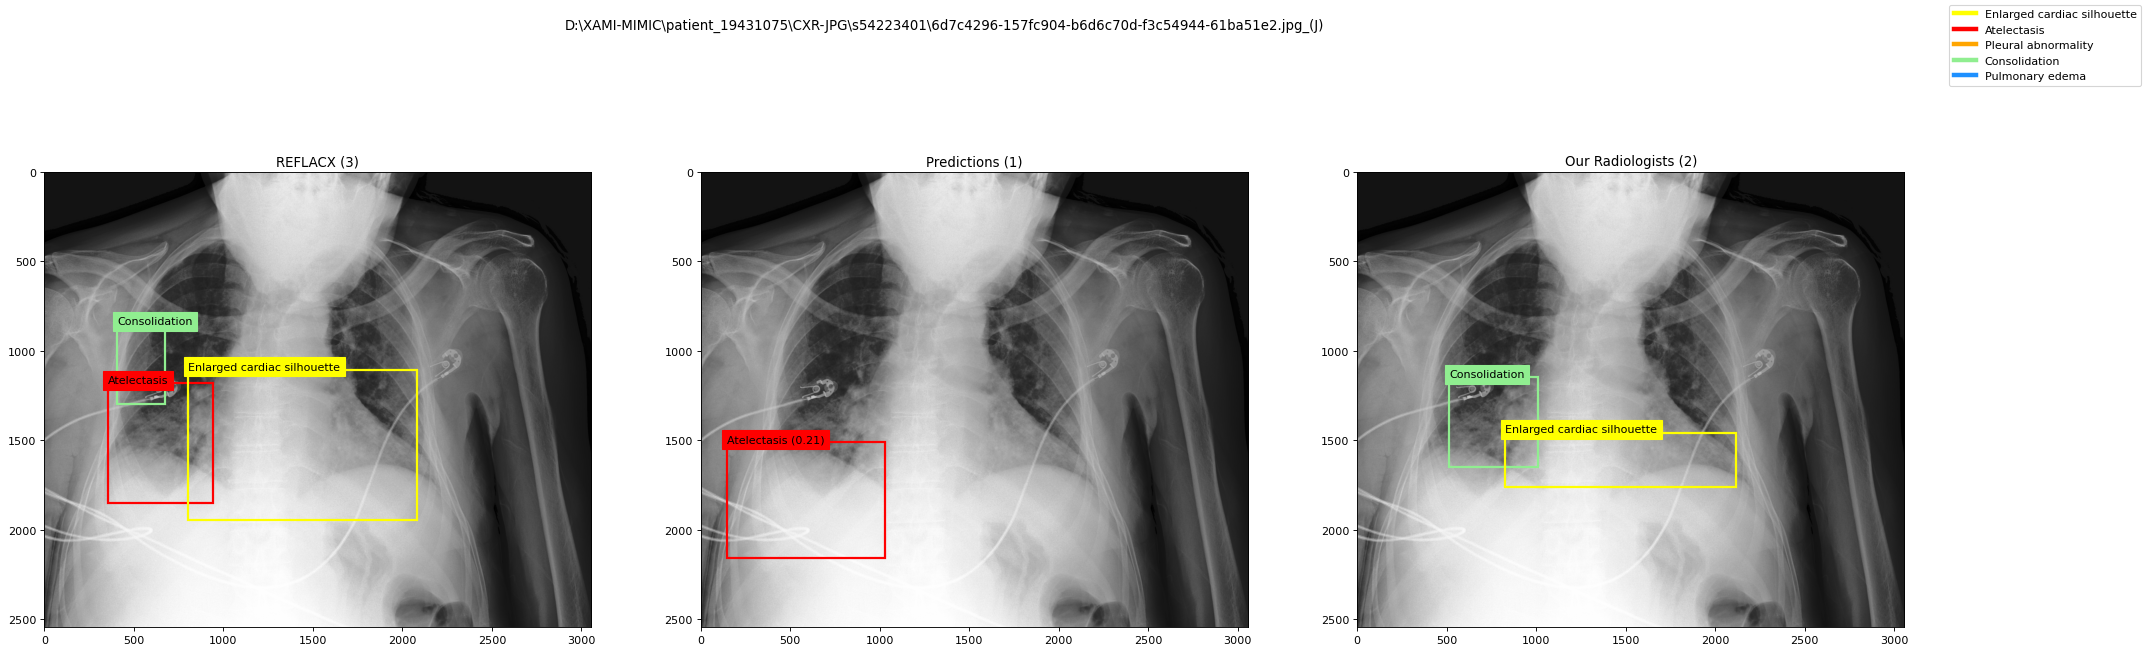

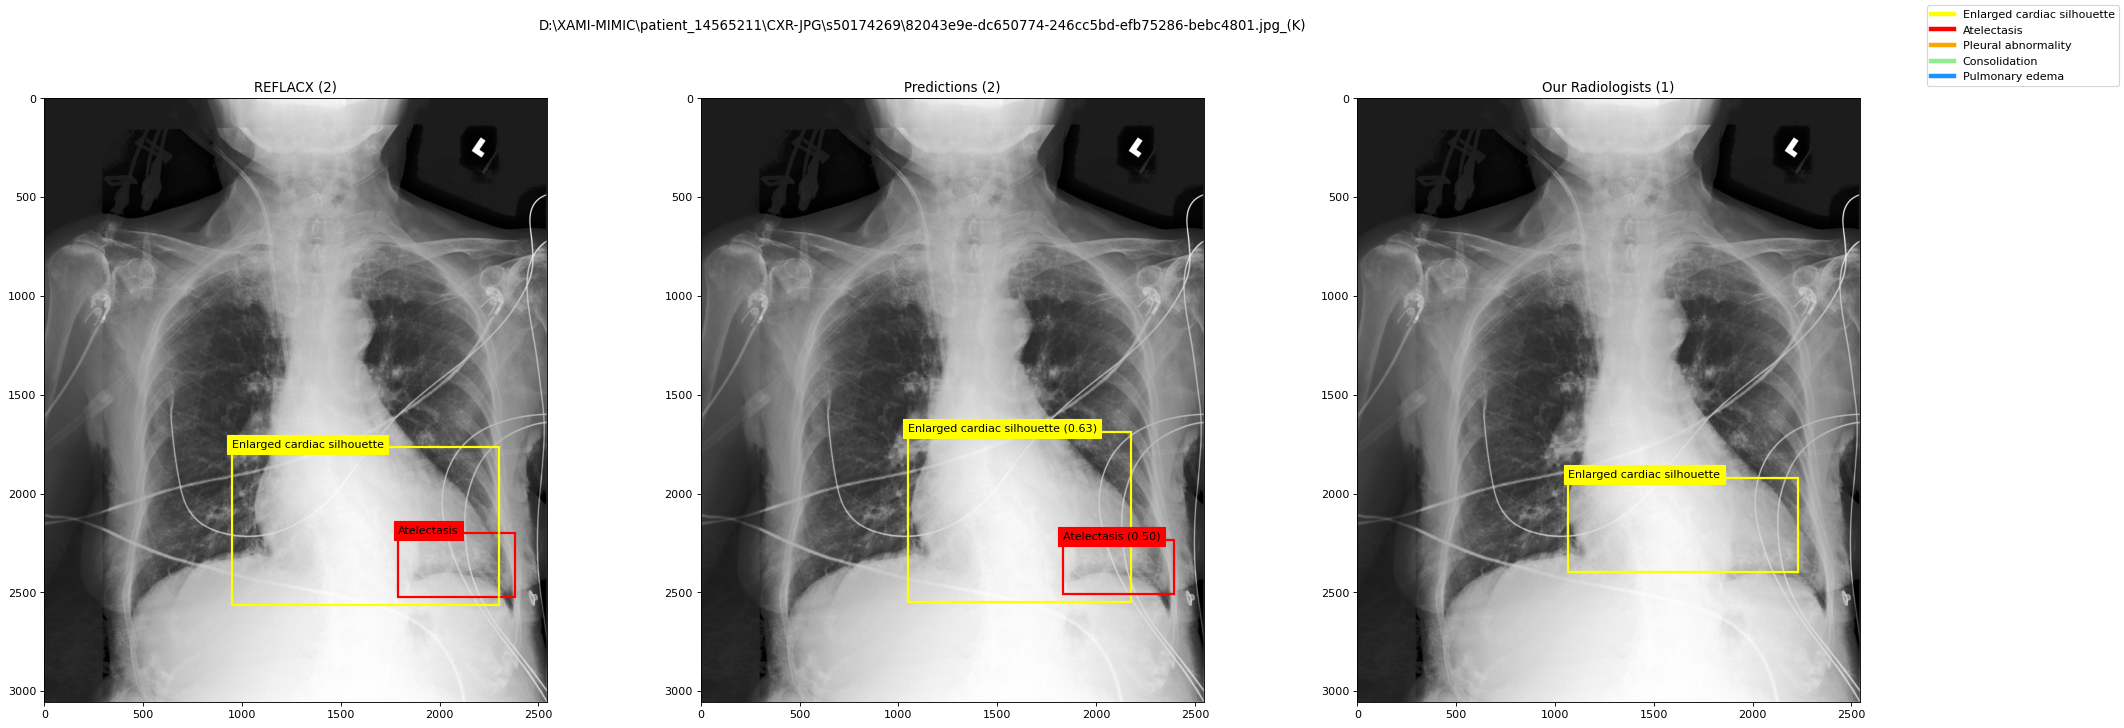

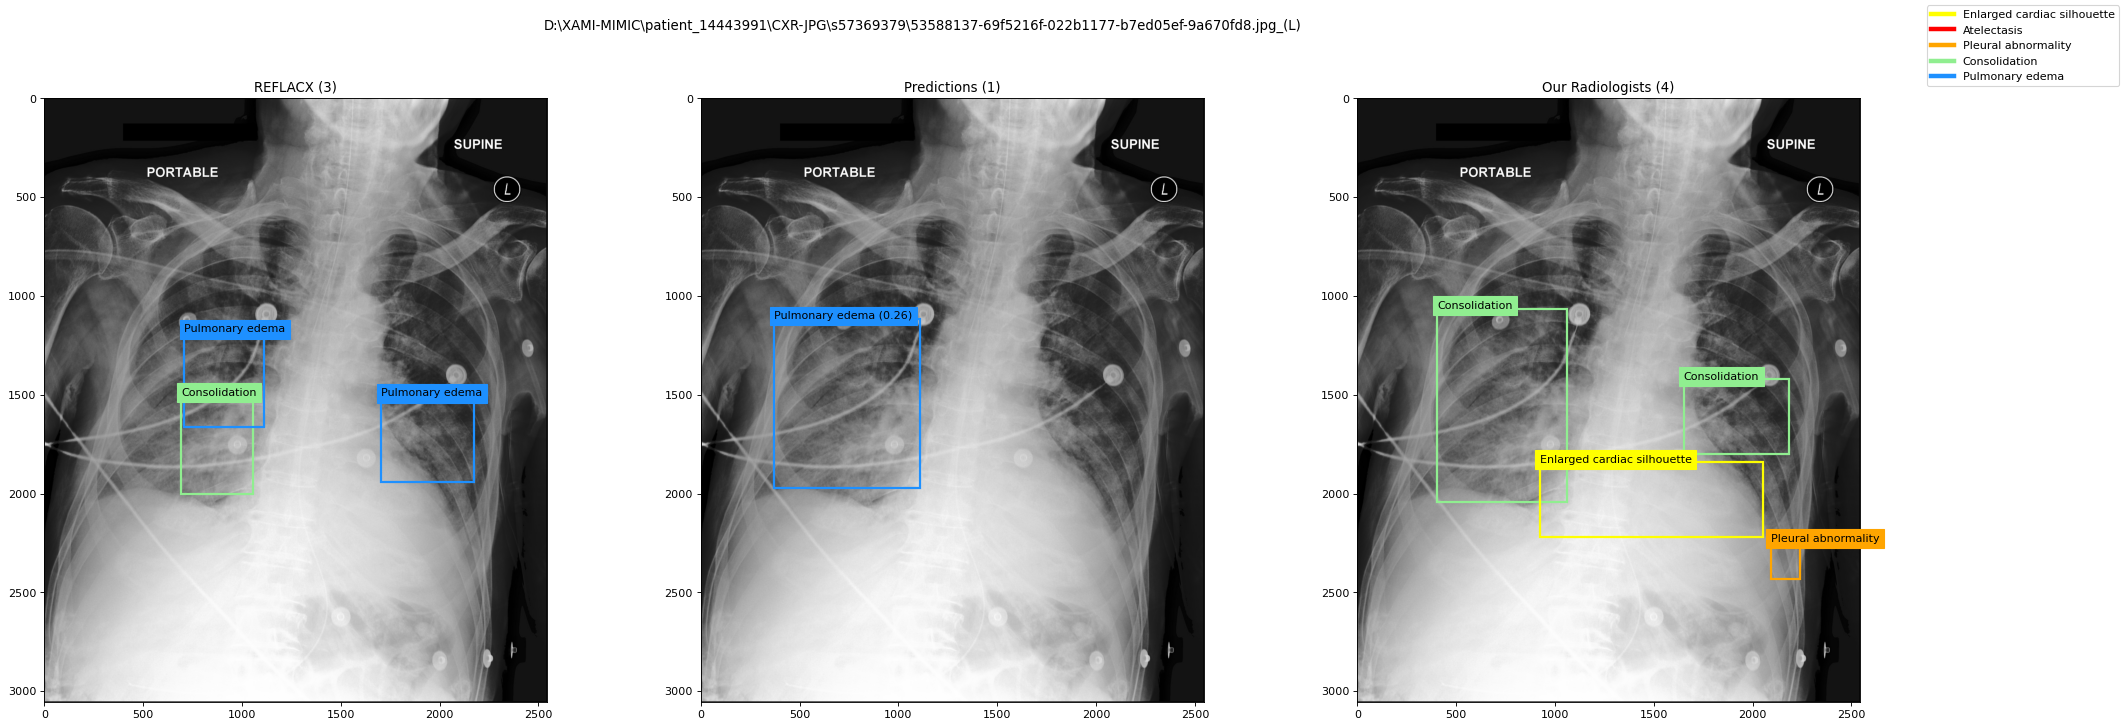

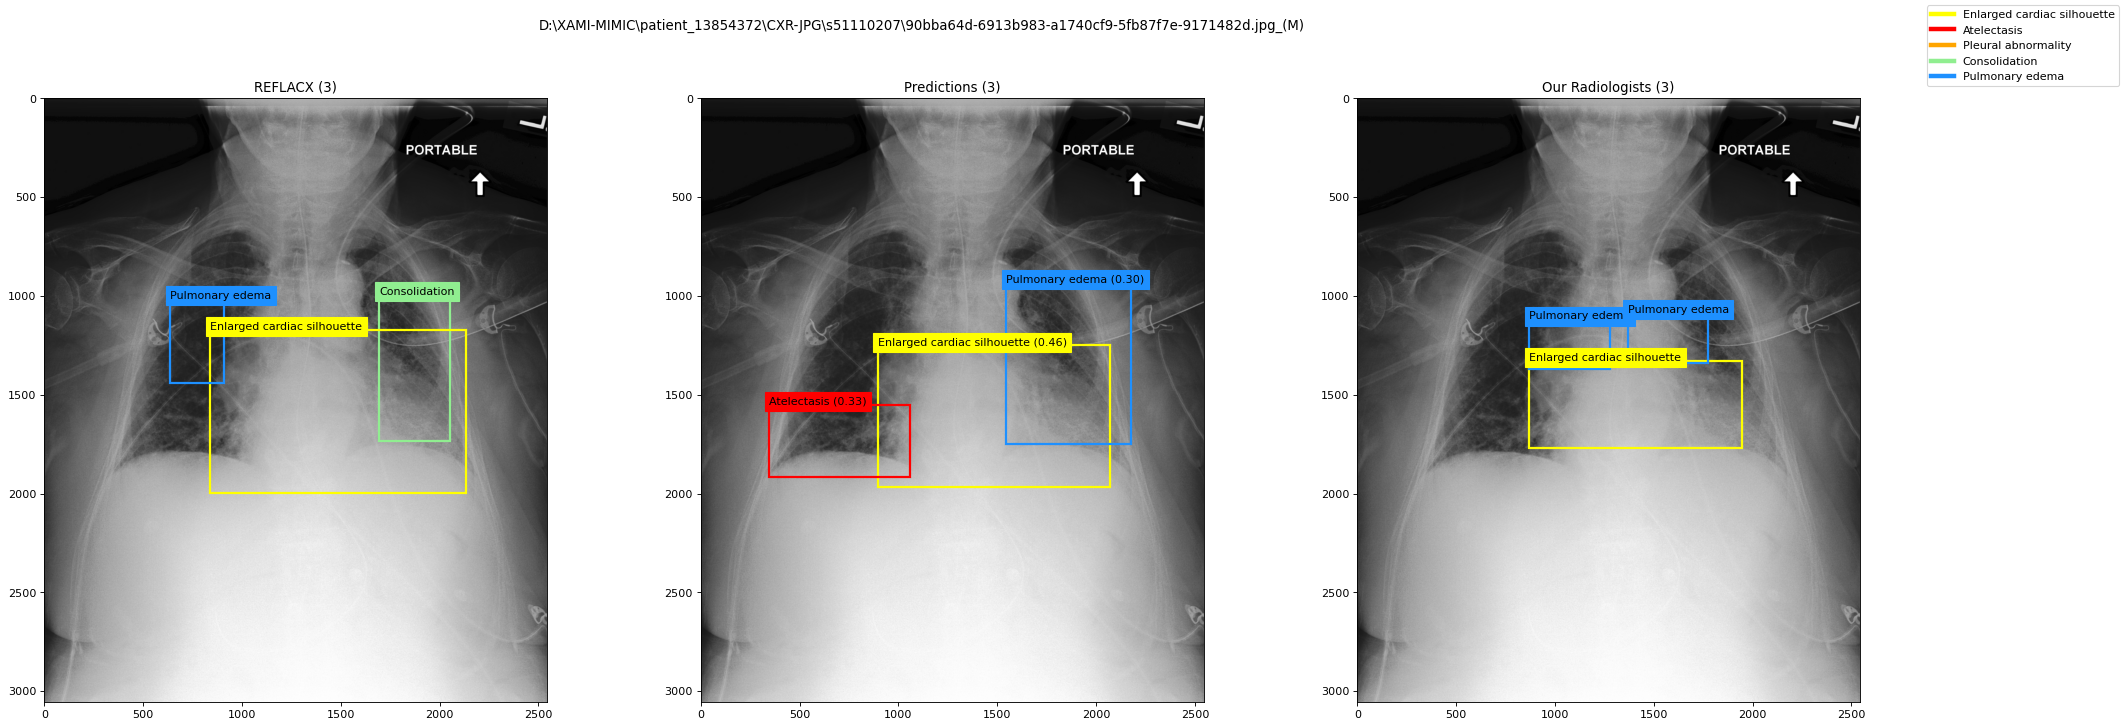

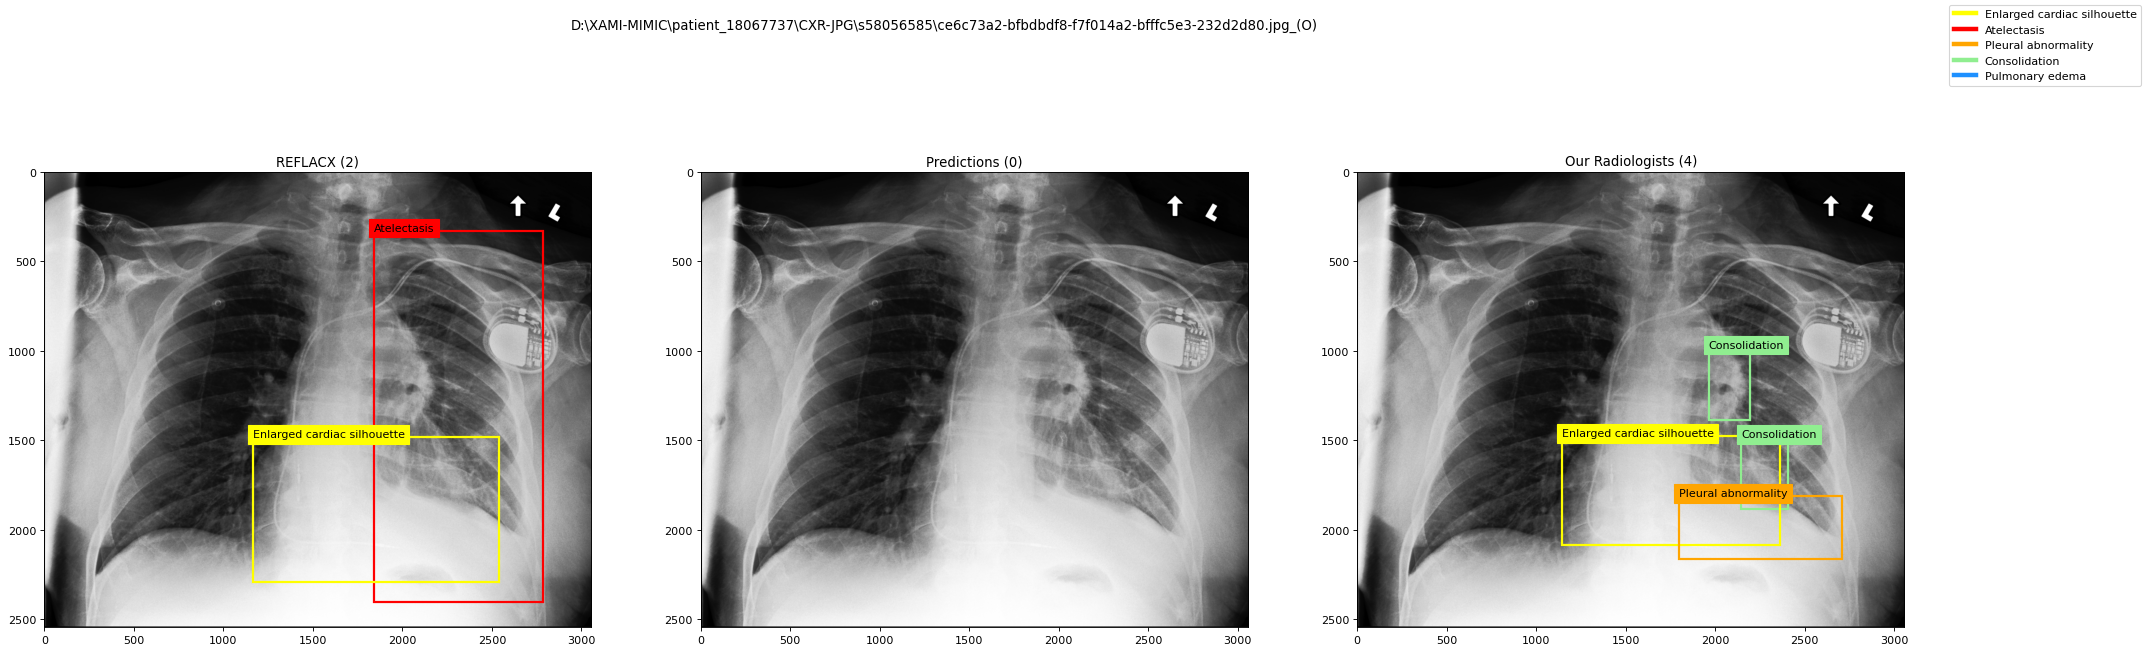

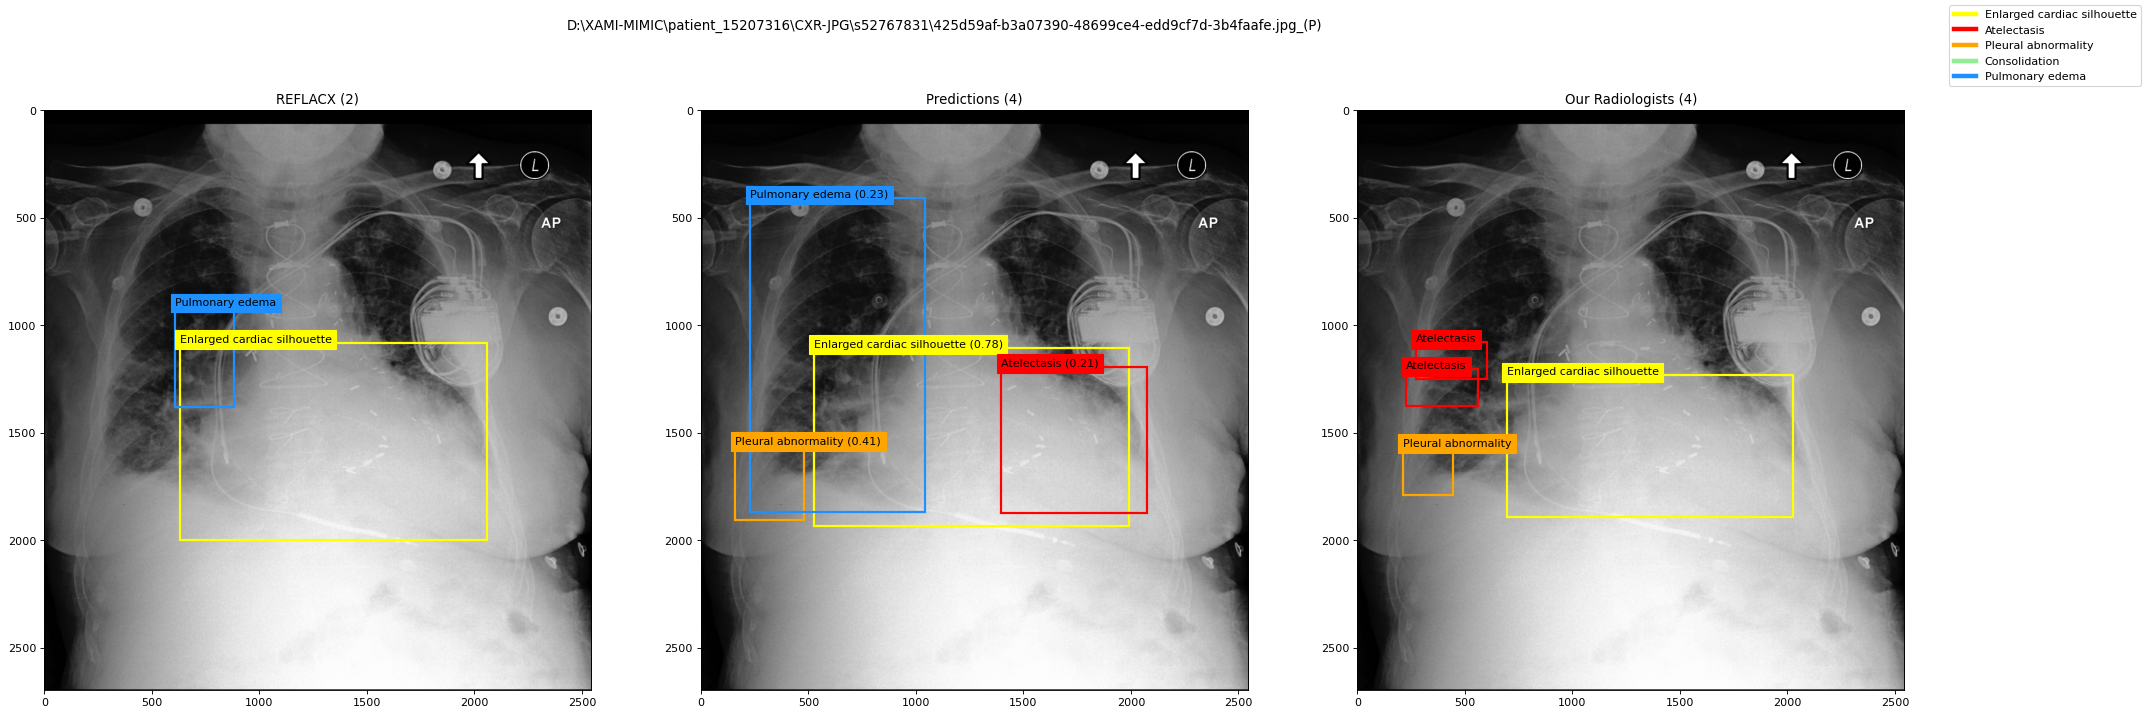

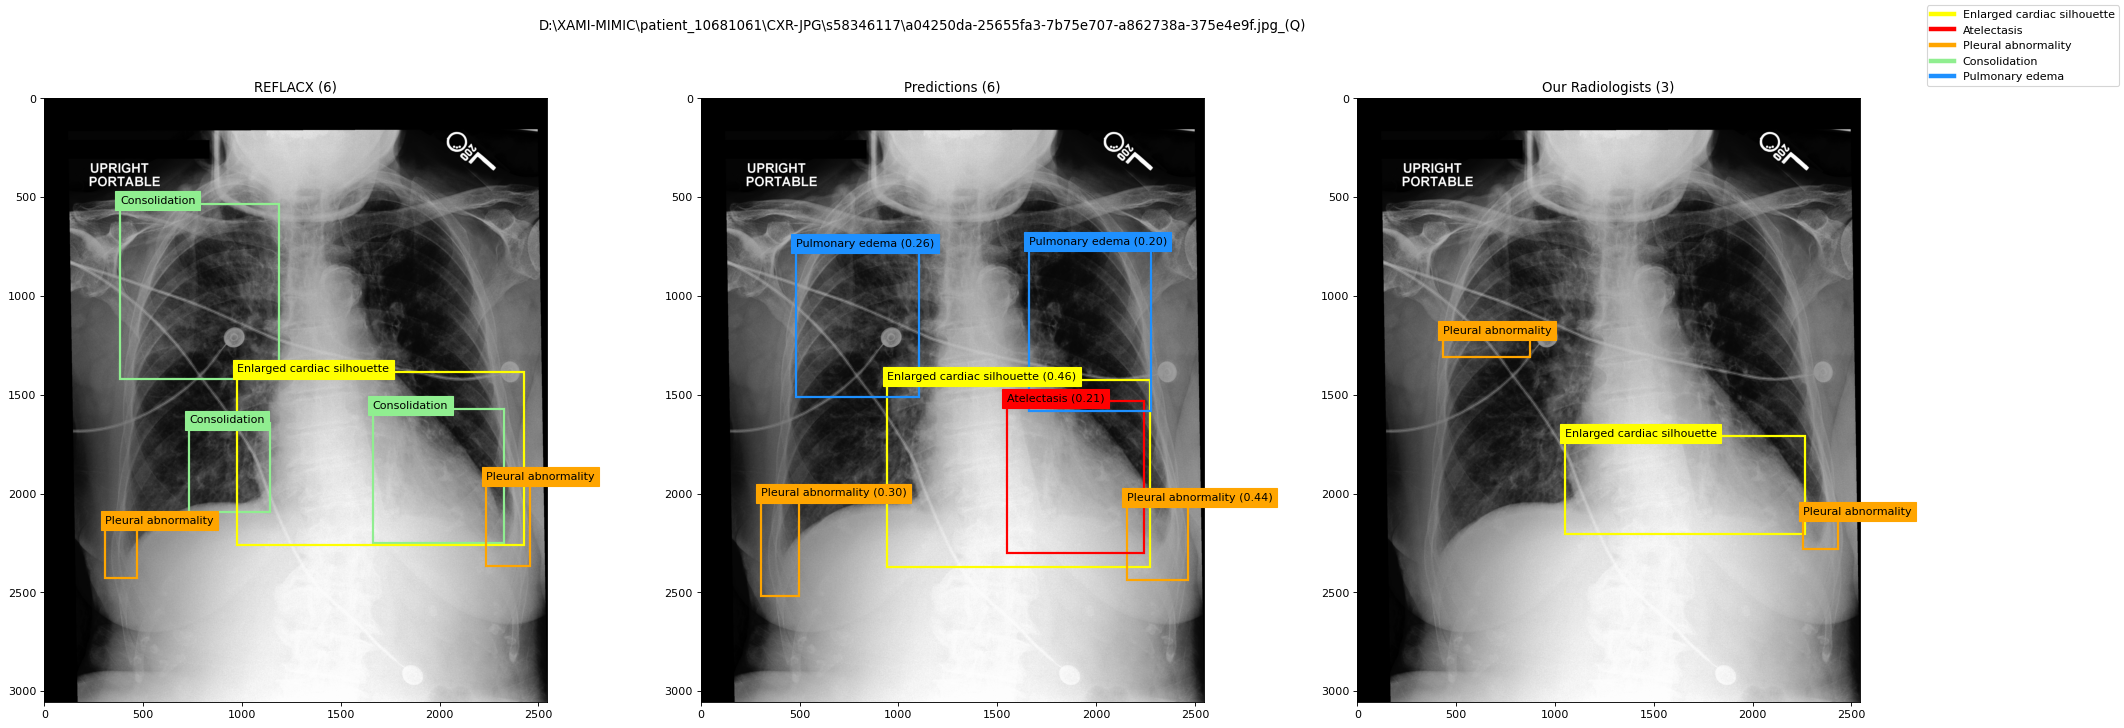

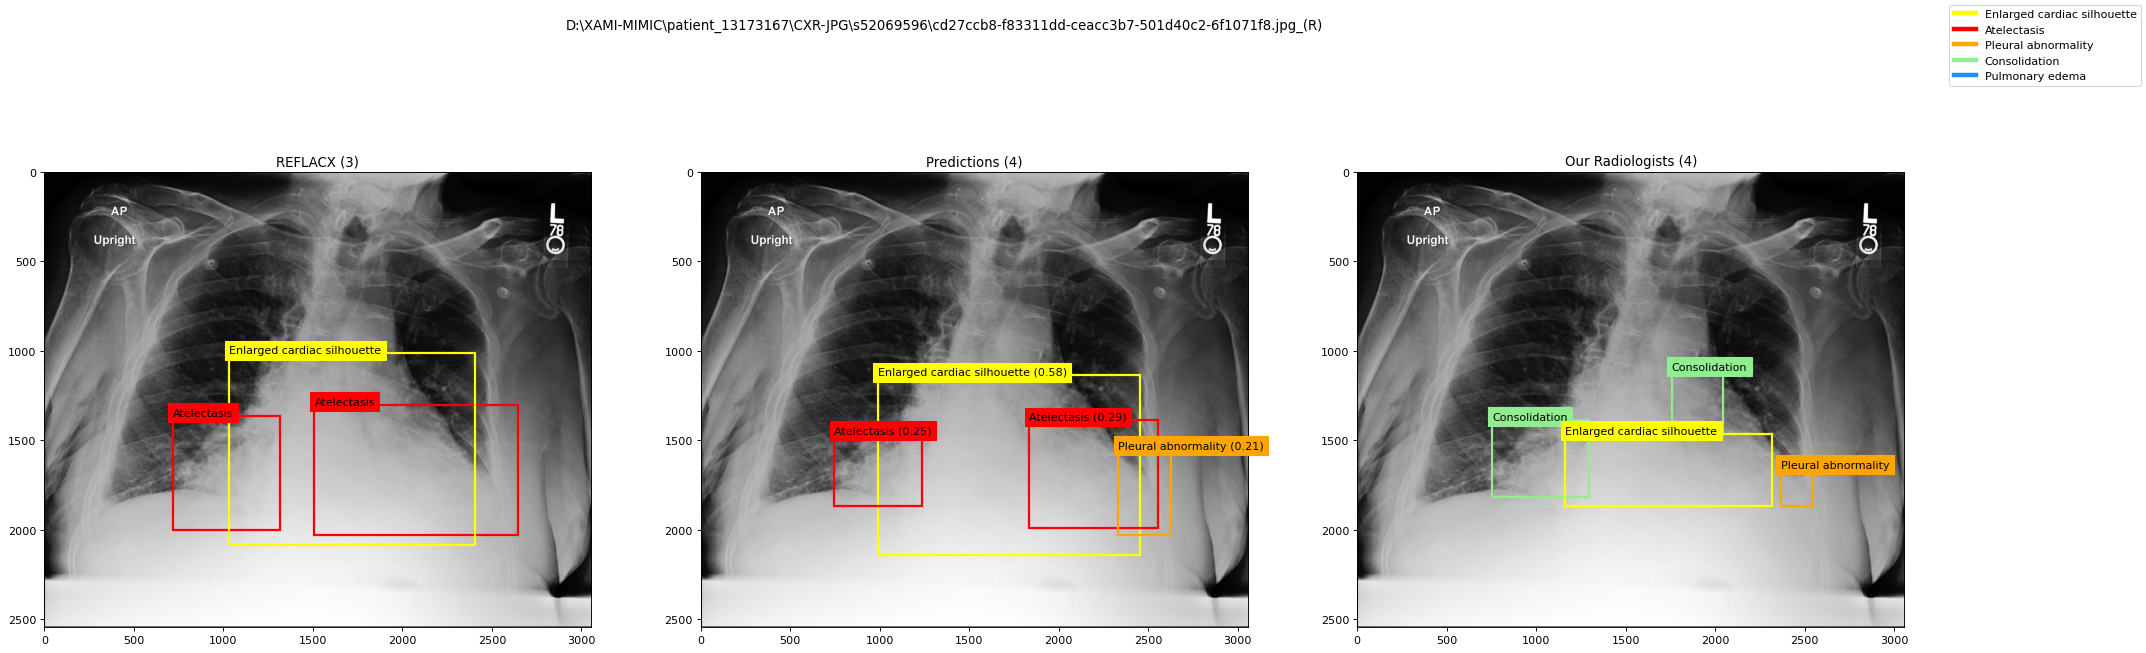

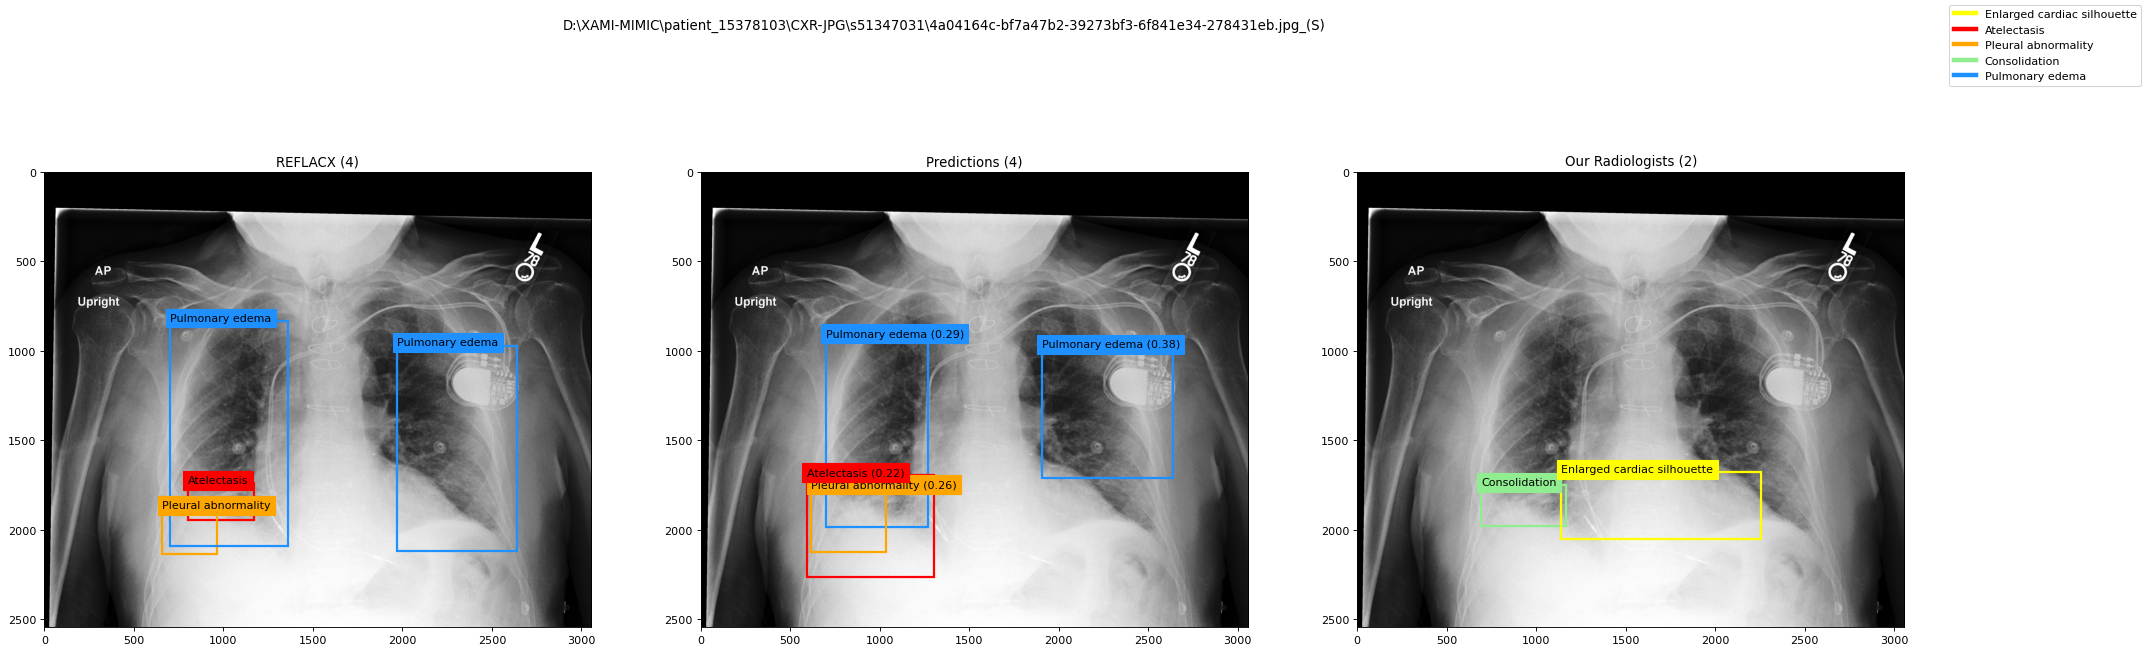

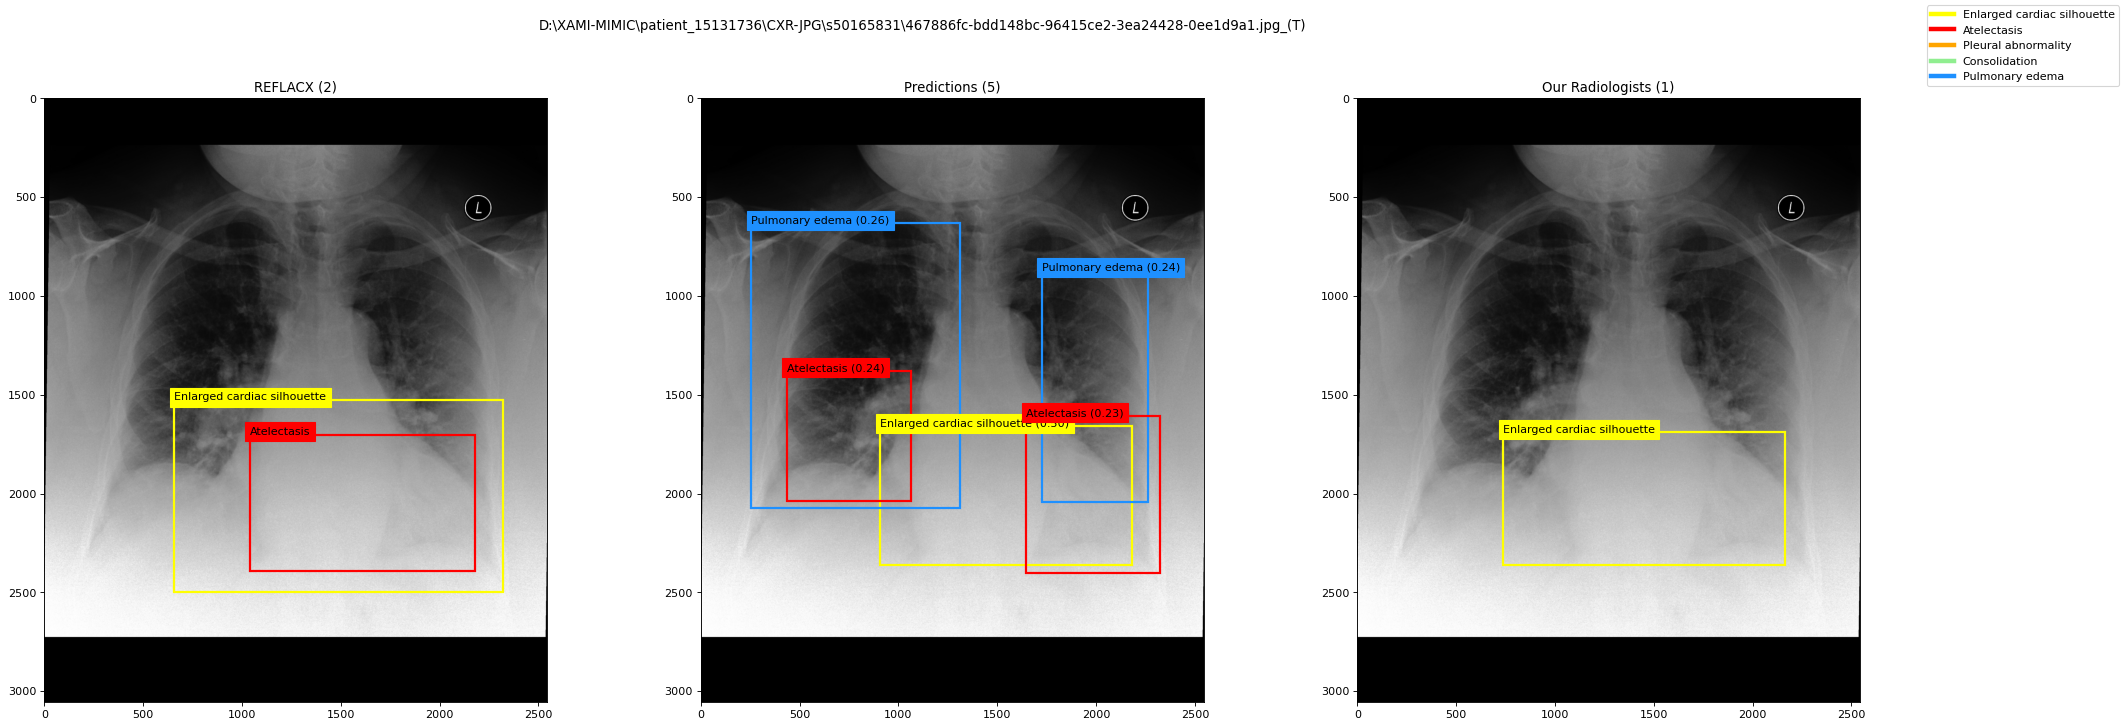

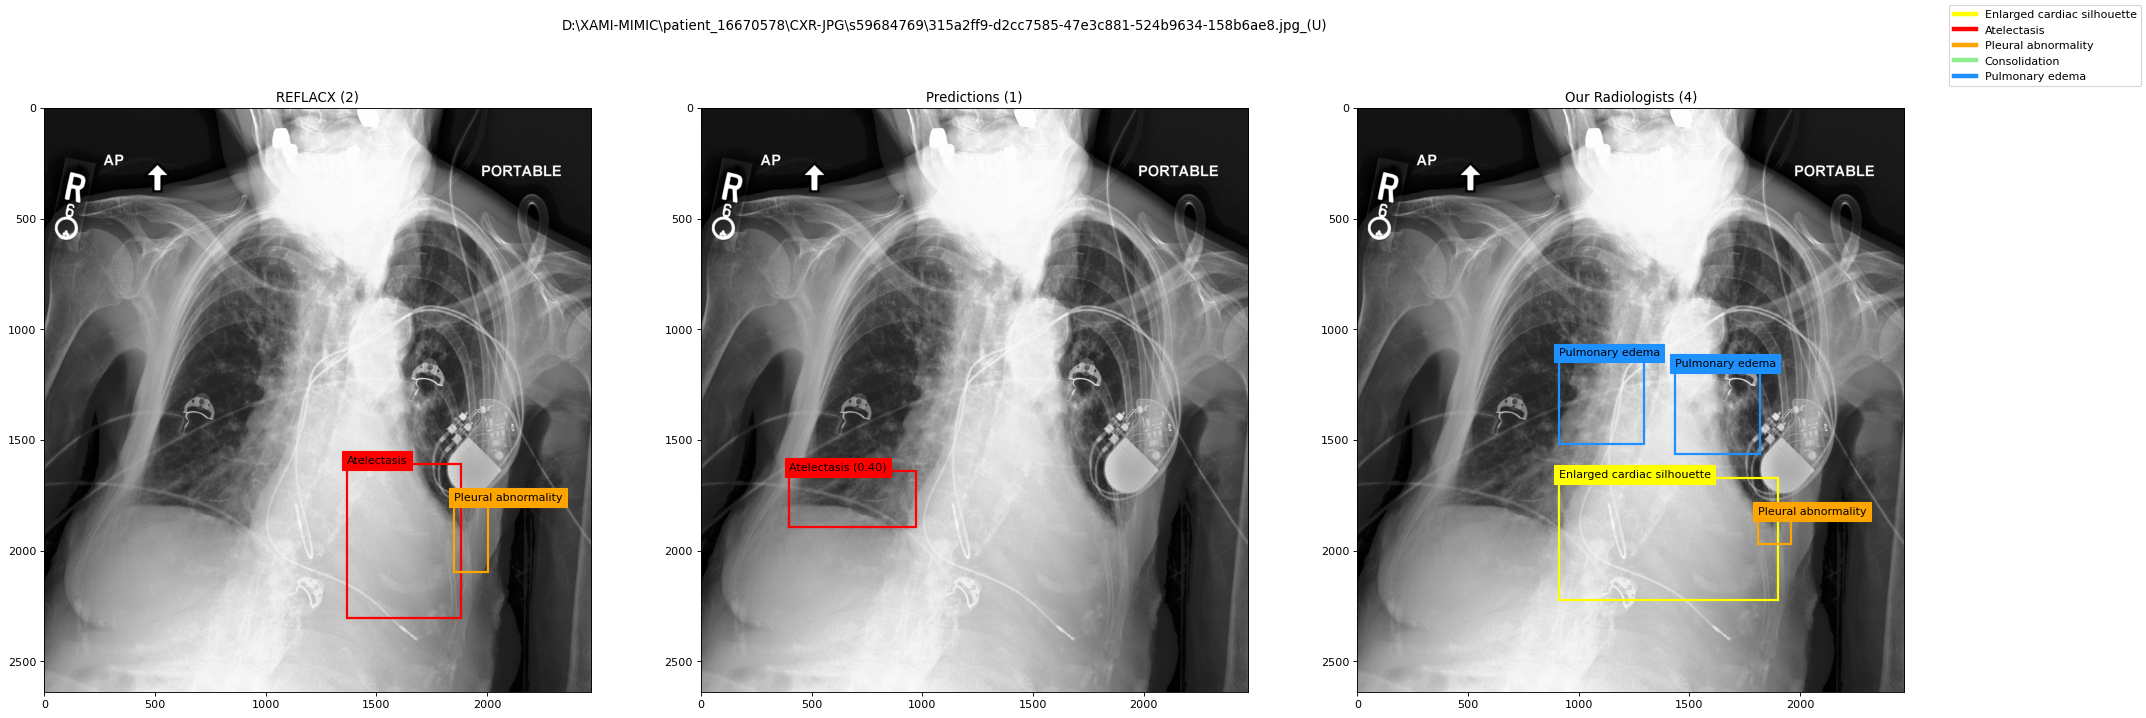

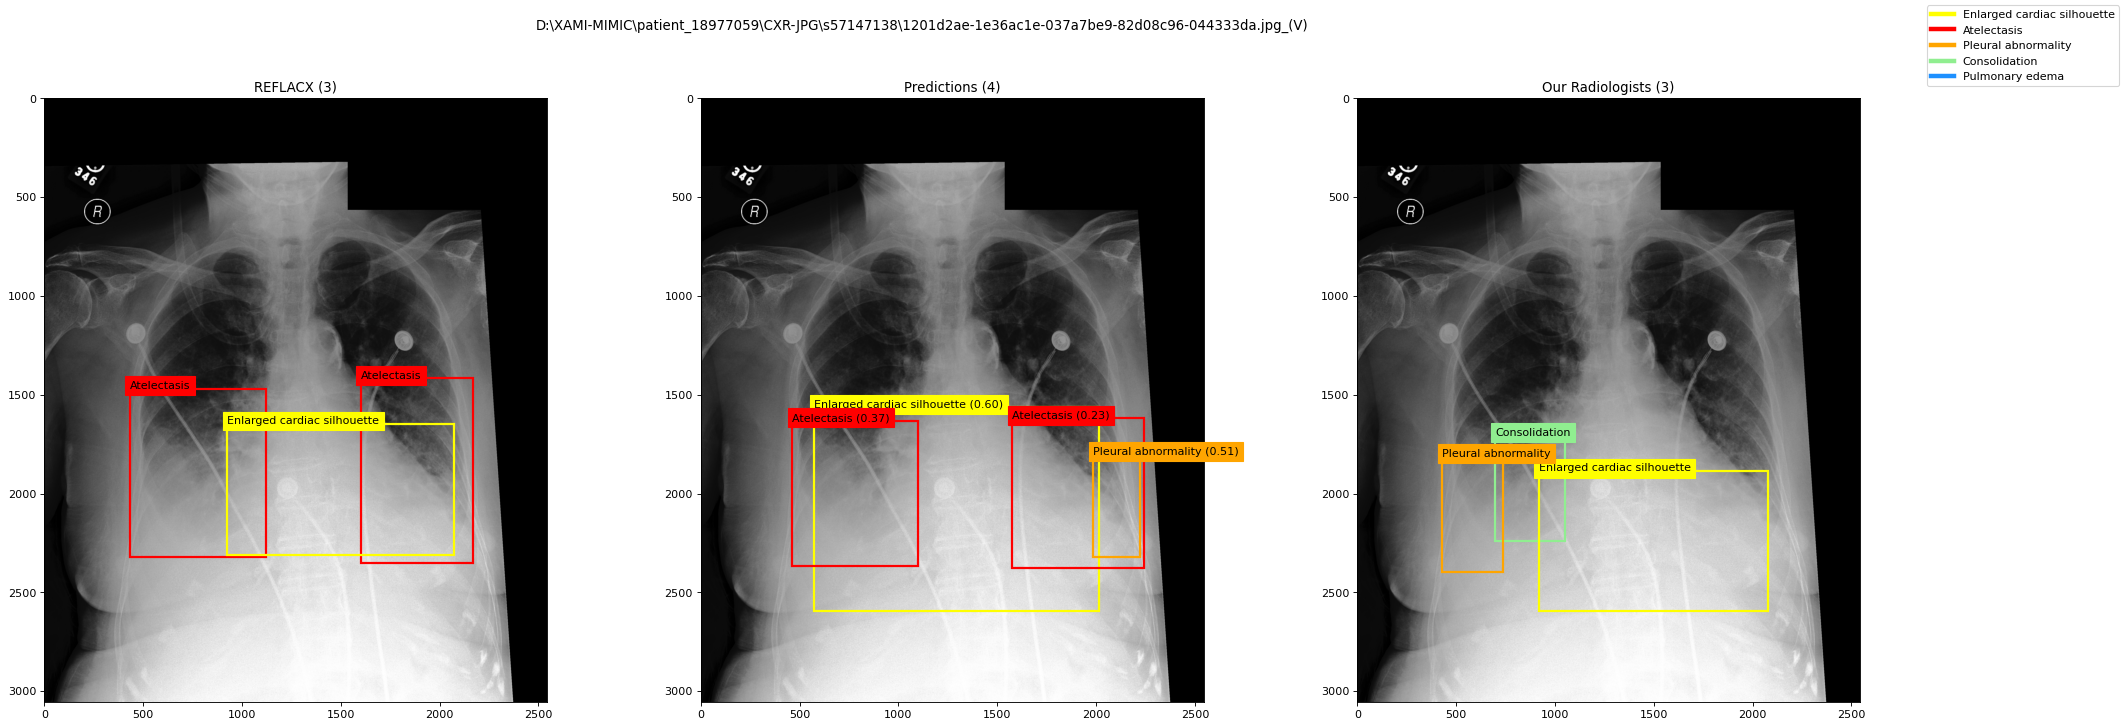

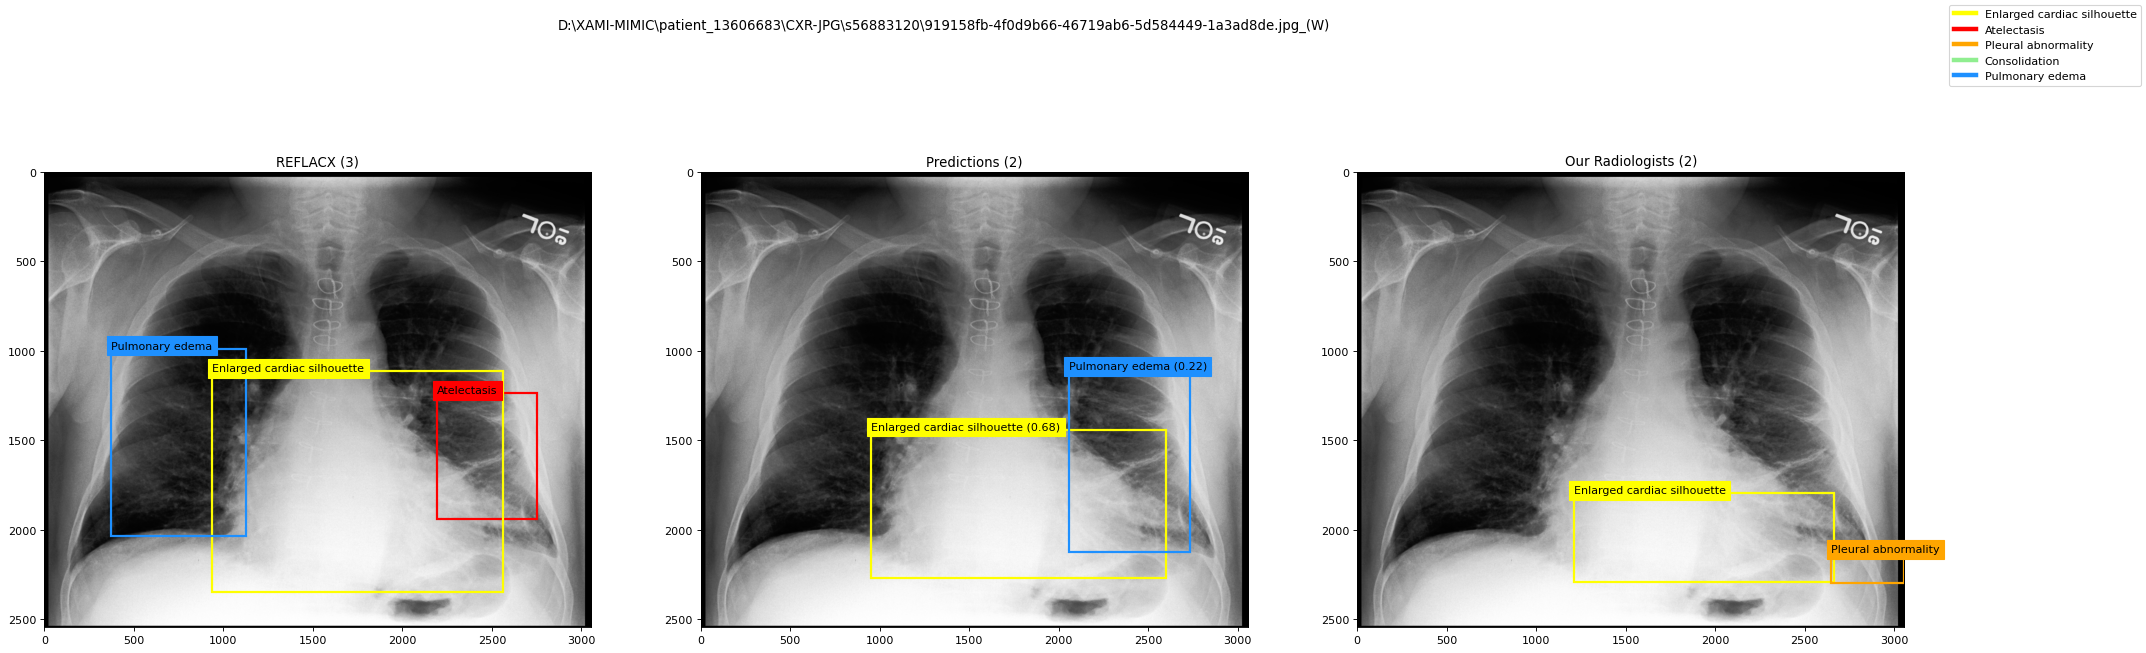

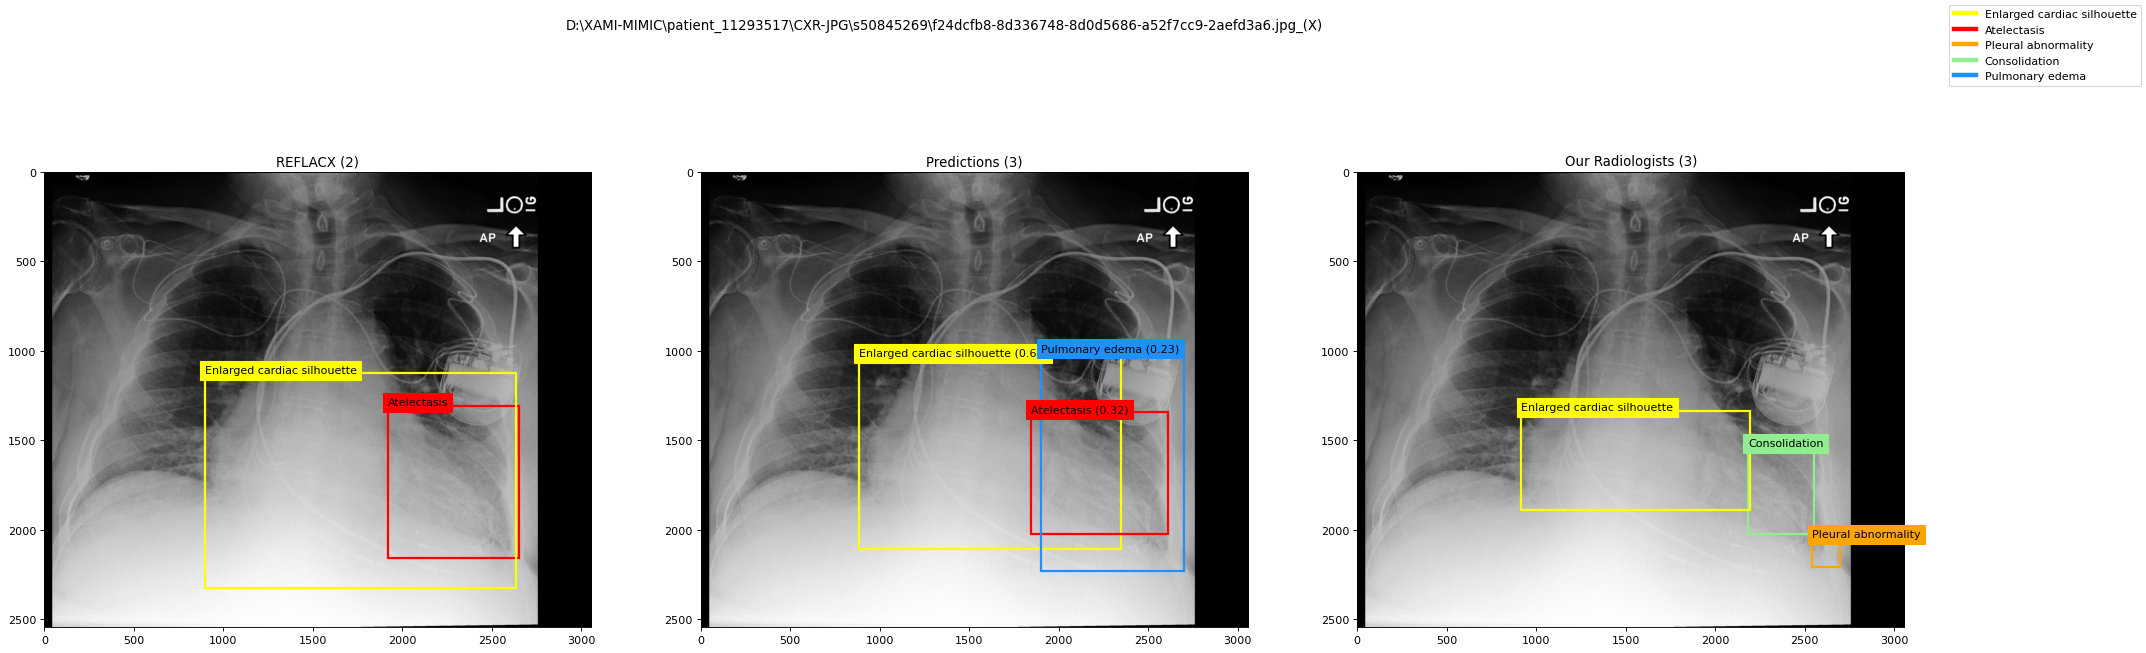

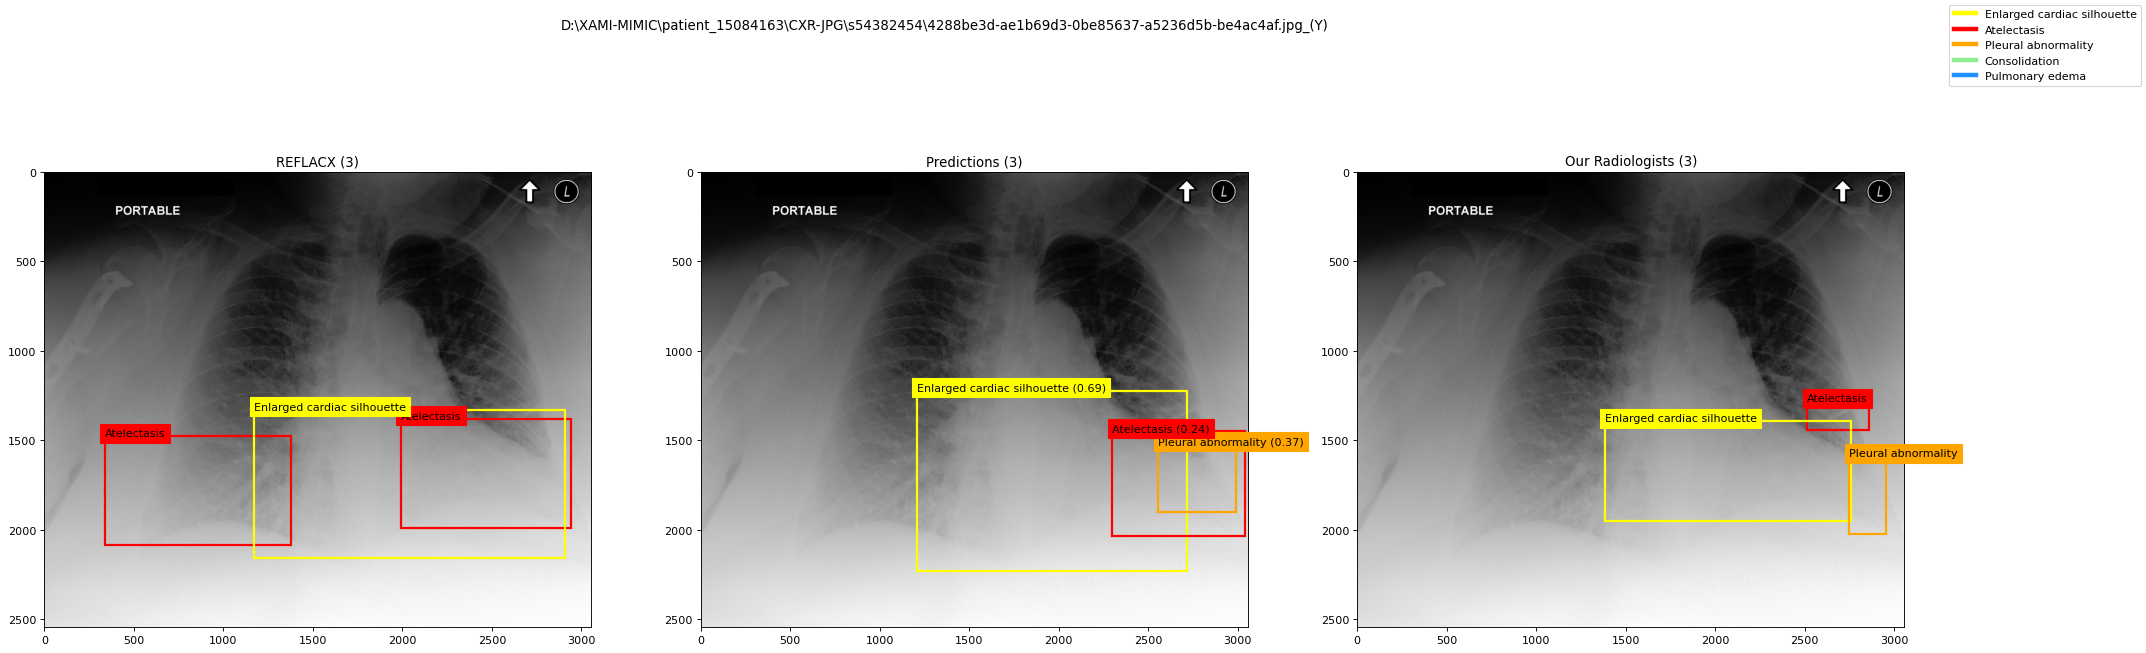

In [14]:
model.roi_heads.score_thresh = 0.01 

for ann in radiologists_anns:
    idx= detect_eval_dataset.get_idxs_from_dicom_id(ann['dicom_id'])[0]
    model.eval()
    data = collate_fn([detect_eval_dataset[idx]])
    data = detect_eval_dataset.prepare_input_from_data(data, device)
    target = data[-1]
    pred = model(*data[:-1])
    pred = pred[0]
    pred = pred_thrs_check(pred, detect_eval_dataset, score_thres, device)

    fig = plot_three_bbox(
        ann,
        target[0],
        pred,
        detect_eval_dataset.label_idx_to_disease,
        legend_elements,
        disease_cmap["solid"],
    )

    save_dir = os.path.join("radiologist_ann_results", "with_clinical"if use_clinical else "without_clinical", ann['encoding'])
    os.makedirs(save_dir, exist_ok=True)
    fig.savefig(os.path.join(save_dir, f"{ann['dicom_id']}.jpg"))
